# *房价预测*

# 数据分析

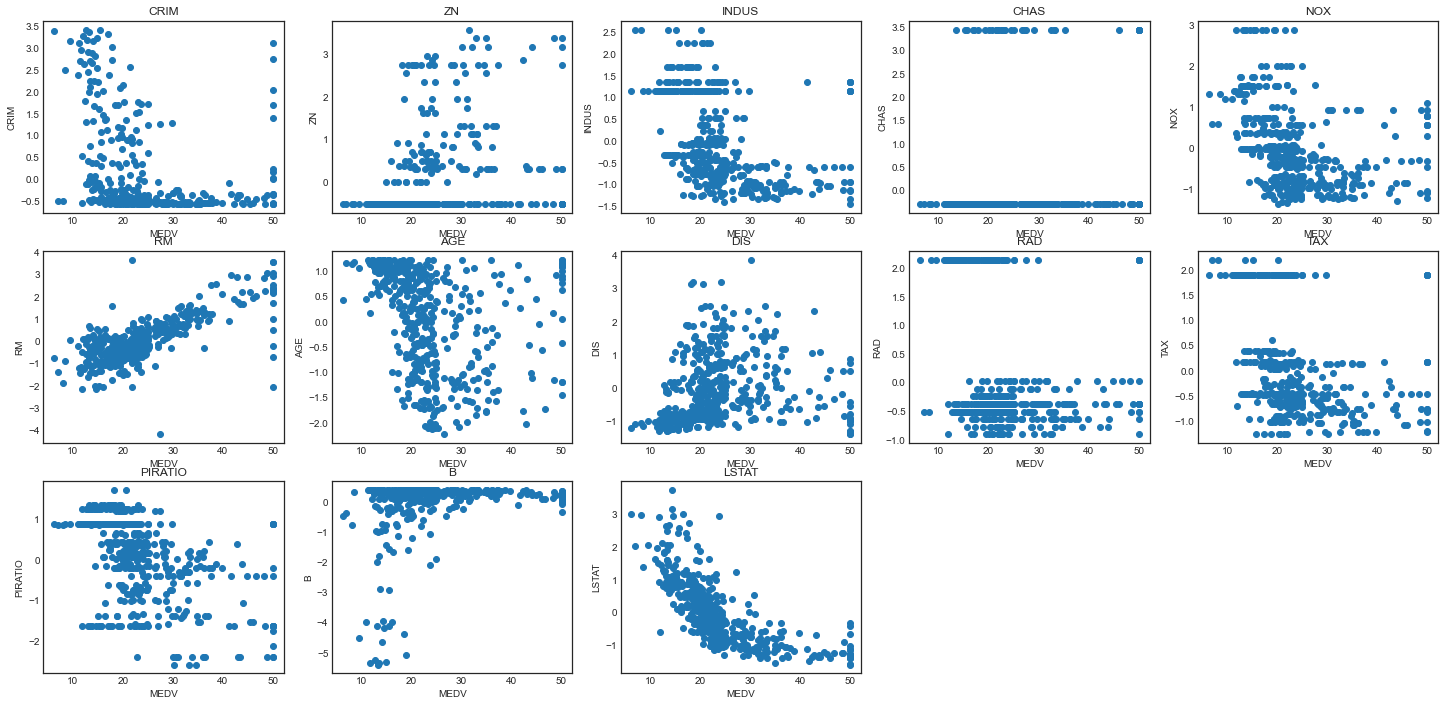

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

data = pd.read_csv(r'./boston_housing_data.csv')
data = data.dropna()
money = data.loc[:, ["MEDV"]].to_numpy()
# 标准化数据
data.iloc[:, :-1] = data.iloc[:, :-1].apply(lambda x: (x - x.mean()) / (x.std()))
fig = plt.figure(figsize=(25,12))
for i in range(13):
    plt.subplot(3,5,i+1)    
    plt.scatter(x=data.iloc[:,-1],y=data.iloc[:,i])
    plt.xlabel("MEDV")
    plt.ylabel(data.columns[i])
    plt.title(data.columns[i])
plt.show()

# 制作数据集

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random


# 数据标准化
def data_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean()) / x.std())

# 数据集
class dataset(Dataset):
    def __init__(self, filePath, train=True):
        self.attributes = []
        self.data = []
        file = pd.read_csv(filePath)
        mean_data = data_norm(file.iloc[:,:-1]).to_numpy()
        if train:
            for i in range(225):
                self.data.append((mean_data[i], file.loc[i, ['MEDV']].values))
            random.shuffle(self.data)
        else:
            for i in range(225, 300):
                self.data.append((mean_data[i], file.loc[i, ['MEDV']]))

    def __getitem__(self, index):
        return torch.FloatTensor(self.data[index][:-1]), torch.FloatTensor(self.data[index][-1])

    def __len__(self):
        return len(self.data)


# 训练两种神经网络

## 定义网络结构

### 单层神经网络

$$\sum_{i=0}^{12}w_ix_i+bias$$

In [3]:
import torch.nn as nn
class SingleLayerNet(nn.Module):
    def __init__(self):
        super(SingleLayerNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(13, 1),
        )
    def forward(self, x):
        out = self.layer1(x)
        return out


### 多层神经网络

In [4]:
import torch.nn as nn
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(13, 256),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 64),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            
        )
        self.layer4 = nn.Sequential(
            nn.Linear(64, 1)
        )

    def forward(self, x):
        layer1_out = self.layer1(x)
        layer2_out = self.layer2(layer1_out)
        layer3_out = self.layer3(layer2_out)
        out = self.layer4(layer3_out)
        return out


## 定义损失函数

In [5]:
class HouseLoss(nn.Module):
    def __init__(self):
        super(HouseLoss, self).__init__()

    def forward(self, input, target):
        return ((input - target)).mean()


## 训练过程

### 超参数

In [6]:
import math
import torch.nn as nn
import torch.optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


batchsize = 3
lr = 0.0001
epochs = 200
dataPath = r".\boston_housing_data.csv"
trainData = dataset(dataPath, True)
valData = dataset(dataPath, False)
trainLoader = DataLoader(trainData, batch_size=batchsize, shuffle=True)
valLoader = DataLoader(valData, batch_size=batchsize)


### 单层神经网络训练

In [7]:
model=SingleLayerNet()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100, 150], 0.1)


loss = nn.MSELoss()
StrainLOSS = []
SvalLOSS = []
SY=[]
SYHat=[]
for epoch in range(epochs):
    model.train()
    trainLoss = 0
    for batch, (x, y) in enumerate(trainLoader):
        x, y = Variable(x), Variable(y)
        yHat = model(x)
        los = loss(yHat, y.view(batchsize,1,1)).mean()
        trainLoss += los
        print('epoch:%d\tbatch:%d/%d\tTrain Loss:%.3f' %
              (epoch, batch + 1, math.ceil(len(trainData) / batchsize), los))
        optimizer.zero_grad()
        los.backward()
        optimizer.step()
    scheduler.step()
    print('Train Loss:%.3f\t' %
          (trainLoss / math.ceil(len(trainData) / batchsize)))
    StrainLOSS.append(trainLoss / math.ceil(len(trainData) / batchsize))
    model.eval()
    valLoss = 0
    for batch, (x, y) in enumerate(valLoader):
        x, y = Variable(x), Variable(y)
        yHat = model(x)
        los = loss(yHat, y.view(batchsize,1,1))
        valLoss += los
        SY.append(y.sum()/batchsize)
        SYHat.append(yHat.sum()/batchsize)
    print('Val Loss:%.3f' %
          (valLoss / math.ceil(len(valData) / batchsize)))
    SvalLOSS.append(valLoss / math.ceil(len(valData) / batchsize))
    if epoch + 1 in [50, 60, 70, 80, 90, 100,200]:
        torch.save(model.state_dict(), 'output/SingleNetparams_' + str(epoch + 1) + '.pth')

C:\Users\ZHN\AppData\Local\Temp/ipykernel_10440/856850426.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  return torch.FloatTensor(self.data[index][:-1]), torch.FloatTensor(self.data[index][-1])


epoch:0	batch:1/75	Train Loss:536.423
epoch:0	batch:2/75	Train Loss:197.323
epoch:0	batch:3/75	Train Loss:932.963
epoch:0	batch:4/75	Train Loss:405.763
epoch:0	batch:5/75	Train Loss:546.390
epoch:0	batch:6/75	Train Loss:525.842
epoch:0	batch:7/75	Train Loss:1195.695
epoch:0	batch:8/75	Train Loss:782.259
epoch:0	batch:9/75	Train Loss:473.984
epoch:0	batch:10/75	Train Loss:753.002
epoch:0	batch:11/75	Train Loss:516.268
epoch:0	batch:12/75	Train Loss:370.092
epoch:0	batch:13/75	Train Loss:612.742
epoch:0	batch:14/75	Train Loss:1016.308
epoch:0	batch:15/75	Train Loss:414.143
epoch:0	batch:16/75	Train Loss:676.822
epoch:0	batch:17/75	Train Loss:385.570
epoch:0	batch:18/75	Train Loss:1005.938
epoch:0	batch:19/75	Train Loss:394.983
epoch:0	batch:20/75	Train Loss:864.826
epoch:0	batch:21/75	Train Loss:584.481
epoch:0	batch:22/75	Train Loss:459.824
epoch:0	batch:23/75	Train Loss:1023.519
epoch:0	batch:24/75	Train Loss:609.892
epoch:0	batch:25/75	Train Loss:503.364
epoch:0	batch:26/75	Train Loss

epoch:4	batch:42/75	Train Loss:301.964
epoch:4	batch:43/75	Train Loss:473.825
epoch:4	batch:44/75	Train Loss:764.392
epoch:4	batch:45/75	Train Loss:612.595
epoch:4	batch:46/75	Train Loss:860.178
epoch:4	batch:47/75	Train Loss:416.616
epoch:4	batch:48/75	Train Loss:306.066
epoch:4	batch:49/75	Train Loss:1087.572
epoch:4	batch:50/75	Train Loss:320.695
epoch:4	batch:51/75	Train Loss:395.723
epoch:4	batch:52/75	Train Loss:657.153
epoch:4	batch:53/75	Train Loss:703.019
epoch:4	batch:54/75	Train Loss:229.311
epoch:4	batch:55/75	Train Loss:344.414
epoch:4	batch:56/75	Train Loss:532.346
epoch:4	batch:57/75	Train Loss:756.463
epoch:4	batch:58/75	Train Loss:273.030
epoch:4	batch:59/75	Train Loss:288.212
epoch:4	batch:60/75	Train Loss:363.357
epoch:4	batch:61/75	Train Loss:582.716
epoch:4	batch:62/75	Train Loss:273.416
epoch:4	batch:63/75	Train Loss:1212.271
epoch:4	batch:64/75	Train Loss:462.269
epoch:4	batch:65/75	Train Loss:259.675
epoch:4	batch:66/75	Train Loss:511.061
epoch:4	batch:67/75	Tra

epoch:7	batch:70/75	Train Loss:329.889
epoch:7	batch:71/75	Train Loss:993.673
epoch:7	batch:72/75	Train Loss:220.646
epoch:7	batch:73/75	Train Loss:359.520
epoch:7	batch:74/75	Train Loss:571.742
epoch:7	batch:75/75	Train Loss:468.144
Train Loss:440.293	
Val Loss:736.723
epoch:8	batch:1/75	Train Loss:575.422
epoch:8	batch:2/75	Train Loss:1060.851
epoch:8	batch:3/75	Train Loss:539.275
epoch:8	batch:4/75	Train Loss:434.040
epoch:8	batch:5/75	Train Loss:278.208
epoch:8	batch:6/75	Train Loss:462.371
epoch:8	batch:7/75	Train Loss:1090.531
epoch:8	batch:8/75	Train Loss:872.448
epoch:8	batch:9/75	Train Loss:307.587
epoch:8	batch:10/75	Train Loss:267.858
epoch:8	batch:11/75	Train Loss:225.064
epoch:8	batch:12/75	Train Loss:569.738
epoch:8	batch:13/75	Train Loss:427.891
epoch:8	batch:14/75	Train Loss:206.668
epoch:8	batch:15/75	Train Loss:560.620
epoch:8	batch:16/75	Train Loss:266.430
epoch:8	batch:17/75	Train Loss:393.661
epoch:8	batch:18/75	Train Loss:263.955
epoch:8	batch:19/75	Train Loss:209

epoch:11	batch:45/75	Train Loss:291.967
epoch:11	batch:46/75	Train Loss:224.300
epoch:11	batch:47/75	Train Loss:355.179
epoch:11	batch:48/75	Train Loss:215.395
epoch:11	batch:49/75	Train Loss:190.152
epoch:11	batch:50/75	Train Loss:1115.282
epoch:11	batch:51/75	Train Loss:616.836
epoch:11	batch:52/75	Train Loss:194.849
epoch:11	batch:53/75	Train Loss:240.125
epoch:11	batch:54/75	Train Loss:257.914
epoch:11	batch:55/75	Train Loss:226.441
epoch:11	batch:56/75	Train Loss:794.537
epoch:11	batch:57/75	Train Loss:275.958
epoch:11	batch:58/75	Train Loss:234.727
epoch:11	batch:59/75	Train Loss:307.636
epoch:11	batch:60/75	Train Loss:192.654
epoch:11	batch:61/75	Train Loss:208.015
epoch:11	batch:62/75	Train Loss:382.788
epoch:11	batch:63/75	Train Loss:534.867
epoch:11	batch:64/75	Train Loss:311.296
epoch:11	batch:65/75	Train Loss:389.342
epoch:11	batch:66/75	Train Loss:491.986
epoch:11	batch:67/75	Train Loss:234.754
epoch:11	batch:68/75	Train Loss:150.449
epoch:11	batch:69/75	Train Loss:299.323

epoch:16	batch:7/75	Train Loss:614.048
epoch:16	batch:8/75	Train Loss:230.689
epoch:16	batch:9/75	Train Loss:398.600
epoch:16	batch:10/75	Train Loss:134.042
epoch:16	batch:11/75	Train Loss:741.256
epoch:16	batch:12/75	Train Loss:434.894
epoch:16	batch:13/75	Train Loss:134.522
epoch:16	batch:14/75	Train Loss:245.130
epoch:16	batch:15/75	Train Loss:324.297
epoch:16	batch:16/75	Train Loss:717.061
epoch:16	batch:17/75	Train Loss:587.526
epoch:16	batch:18/75	Train Loss:75.753
epoch:16	batch:19/75	Train Loss:166.720
epoch:16	batch:20/75	Train Loss:268.328
epoch:16	batch:21/75	Train Loss:301.829
epoch:16	batch:22/75	Train Loss:157.076
epoch:16	batch:23/75	Train Loss:435.487
epoch:16	batch:24/75	Train Loss:167.430
epoch:16	batch:25/75	Train Loss:279.979
epoch:16	batch:26/75	Train Loss:137.868
epoch:16	batch:27/75	Train Loss:785.173
epoch:16	batch:28/75	Train Loss:278.189
epoch:16	batch:29/75	Train Loss:253.268
epoch:16	batch:30/75	Train Loss:355.482
epoch:16	batch:31/75	Train Loss:186.162
epoc

epoch:19	batch:25/75	Train Loss:146.401
epoch:19	batch:26/75	Train Loss:132.412
epoch:19	batch:27/75	Train Loss:251.544
epoch:19	batch:28/75	Train Loss:82.445
epoch:19	batch:29/75	Train Loss:117.172
epoch:19	batch:30/75	Train Loss:229.537
epoch:19	batch:31/75	Train Loss:299.450
epoch:19	batch:32/75	Train Loss:245.155
epoch:19	batch:33/75	Train Loss:220.876
epoch:19	batch:34/75	Train Loss:123.157
epoch:19	batch:35/75	Train Loss:137.932
epoch:19	batch:36/75	Train Loss:88.986
epoch:19	batch:37/75	Train Loss:244.447
epoch:19	batch:38/75	Train Loss:838.290
epoch:19	batch:39/75	Train Loss:101.141
epoch:19	batch:40/75	Train Loss:227.243
epoch:19	batch:41/75	Train Loss:277.961
epoch:19	batch:42/75	Train Loss:349.084
epoch:19	batch:43/75	Train Loss:146.865
epoch:19	batch:44/75	Train Loss:174.114
epoch:19	batch:45/75	Train Loss:155.498
epoch:19	batch:46/75	Train Loss:201.251
epoch:19	batch:47/75	Train Loss:236.749
epoch:19	batch:48/75	Train Loss:116.375
epoch:19	batch:49/75	Train Loss:67.267
epo

epoch:24	batch:23/75	Train Loss:111.618
epoch:24	batch:24/75	Train Loss:97.299
epoch:24	batch:25/75	Train Loss:214.814
epoch:24	batch:26/75	Train Loss:163.224
epoch:24	batch:27/75	Train Loss:146.273
epoch:24	batch:28/75	Train Loss:70.875
epoch:24	batch:29/75	Train Loss:208.210
epoch:24	batch:30/75	Train Loss:157.742
epoch:24	batch:31/75	Train Loss:237.627
epoch:24	batch:32/75	Train Loss:105.678
epoch:24	batch:33/75	Train Loss:143.668
epoch:24	batch:34/75	Train Loss:457.052
epoch:24	batch:35/75	Train Loss:654.911
epoch:24	batch:36/75	Train Loss:562.022
epoch:24	batch:37/75	Train Loss:104.200
epoch:24	batch:38/75	Train Loss:197.236
epoch:24	batch:39/75	Train Loss:157.566
epoch:24	batch:40/75	Train Loss:522.267
epoch:24	batch:41/75	Train Loss:76.217
epoch:24	batch:42/75	Train Loss:792.902
epoch:24	batch:43/75	Train Loss:416.839
epoch:24	batch:44/75	Train Loss:219.377
epoch:24	batch:45/75	Train Loss:183.768
epoch:24	batch:46/75	Train Loss:197.453
epoch:24	batch:47/75	Train Loss:144.153
epo

epoch:29	batch:8/75	Train Loss:48.943
epoch:29	batch:9/75	Train Loss:11.800
epoch:29	batch:10/75	Train Loss:99.576
epoch:29	batch:11/75	Train Loss:179.571
epoch:29	batch:12/75	Train Loss:147.073
epoch:29	batch:13/75	Train Loss:308.877
epoch:29	batch:14/75	Train Loss:88.854
epoch:29	batch:15/75	Train Loss:136.309
epoch:29	batch:16/75	Train Loss:334.091
epoch:29	batch:17/75	Train Loss:143.824
epoch:29	batch:18/75	Train Loss:109.938
epoch:29	batch:19/75	Train Loss:55.315
epoch:29	batch:20/75	Train Loss:54.797
epoch:29	batch:21/75	Train Loss:118.924
epoch:29	batch:22/75	Train Loss:49.606
epoch:29	batch:23/75	Train Loss:254.244
epoch:29	batch:24/75	Train Loss:209.982
epoch:29	batch:25/75	Train Loss:89.034
epoch:29	batch:26/75	Train Loss:137.271
epoch:29	batch:27/75	Train Loss:76.371
epoch:29	batch:28/75	Train Loss:821.191
epoch:29	batch:29/75	Train Loss:120.902
epoch:29	batch:30/75	Train Loss:173.785
epoch:29	batch:31/75	Train Loss:171.171
epoch:29	batch:32/75	Train Loss:30.881
epoch:29	bat

epoch:35	batch:13/75	Train Loss:42.698
epoch:35	batch:14/75	Train Loss:36.856
epoch:35	batch:15/75	Train Loss:370.511
epoch:35	batch:16/75	Train Loss:43.814
epoch:35	batch:17/75	Train Loss:44.639
epoch:35	batch:18/75	Train Loss:359.577
epoch:35	batch:19/75	Train Loss:47.191
epoch:35	batch:20/75	Train Loss:32.197
epoch:35	batch:21/75	Train Loss:140.559
epoch:35	batch:22/75	Train Loss:43.863
epoch:35	batch:23/75	Train Loss:86.333
epoch:35	batch:24/75	Train Loss:107.796
epoch:35	batch:25/75	Train Loss:220.897
epoch:35	batch:26/75	Train Loss:32.171
epoch:35	batch:27/75	Train Loss:159.561
epoch:35	batch:28/75	Train Loss:573.569
epoch:35	batch:29/75	Train Loss:20.900
epoch:35	batch:30/75	Train Loss:125.037
epoch:35	batch:31/75	Train Loss:75.028
epoch:35	batch:32/75	Train Loss:350.077
epoch:35	batch:33/75	Train Loss:161.692
epoch:35	batch:34/75	Train Loss:35.168
epoch:35	batch:35/75	Train Loss:470.912
epoch:35	batch:36/75	Train Loss:217.773
epoch:35	batch:37/75	Train Loss:132.308
epoch:35	bat

epoch:37	batch:72/75	Train Loss:57.432
epoch:37	batch:73/75	Train Loss:121.467
epoch:37	batch:74/75	Train Loss:418.891
epoch:37	batch:75/75	Train Loss:59.236
Train Loss:117.177	
Val Loss:245.401
epoch:38	batch:1/75	Train Loss:96.451
epoch:38	batch:2/75	Train Loss:17.064
epoch:38	batch:3/75	Train Loss:55.783
epoch:38	batch:4/75	Train Loss:9.625
epoch:38	batch:5/75	Train Loss:53.158
epoch:38	batch:6/75	Train Loss:179.050
epoch:38	batch:7/75	Train Loss:476.784
epoch:38	batch:8/75	Train Loss:439.073
epoch:38	batch:9/75	Train Loss:39.571
epoch:38	batch:10/75	Train Loss:73.062
epoch:38	batch:11/75	Train Loss:77.227
epoch:38	batch:12/75	Train Loss:24.614
epoch:38	batch:13/75	Train Loss:80.397
epoch:38	batch:14/75	Train Loss:37.288
epoch:38	batch:15/75	Train Loss:5.055
epoch:38	batch:16/75	Train Loss:94.099
epoch:38	batch:17/75	Train Loss:58.213
epoch:38	batch:18/75	Train Loss:221.779
epoch:38	batch:19/75	Train Loss:232.870
epoch:38	batch:20/75	Train Loss:90.004
epoch:38	batch:21/75	Train Loss

epoch:43	batch:49/75	Train Loss:63.130
epoch:43	batch:50/75	Train Loss:11.631
epoch:43	batch:51/75	Train Loss:457.752
epoch:43	batch:52/75	Train Loss:122.977
epoch:43	batch:53/75	Train Loss:101.325
epoch:43	batch:54/75	Train Loss:133.743
epoch:43	batch:55/75	Train Loss:67.720
epoch:43	batch:56/75	Train Loss:85.195
epoch:43	batch:57/75	Train Loss:43.171
epoch:43	batch:58/75	Train Loss:82.458
epoch:43	batch:59/75	Train Loss:17.484
epoch:43	batch:60/75	Train Loss:62.713
epoch:43	batch:61/75	Train Loss:22.806
epoch:43	batch:62/75	Train Loss:121.530
epoch:43	batch:63/75	Train Loss:295.805
epoch:43	batch:64/75	Train Loss:8.203
epoch:43	batch:65/75	Train Loss:272.687
epoch:43	batch:66/75	Train Loss:59.095
epoch:43	batch:67/75	Train Loss:113.722
epoch:43	batch:68/75	Train Loss:9.199
epoch:43	batch:69/75	Train Loss:47.136
epoch:43	batch:70/75	Train Loss:48.460
epoch:43	batch:71/75	Train Loss:93.889
epoch:43	batch:72/75	Train Loss:226.237
epoch:43	batch:73/75	Train Loss:39.960
epoch:43	batch:74/

epoch:47	batch:1/75	Train Loss:76.951
epoch:47	batch:2/75	Train Loss:12.089
epoch:47	batch:3/75	Train Loss:181.120
epoch:47	batch:4/75	Train Loss:143.342
epoch:47	batch:5/75	Train Loss:3.936
epoch:47	batch:6/75	Train Loss:21.360
epoch:47	batch:7/75	Train Loss:66.694
epoch:47	batch:8/75	Train Loss:385.253
epoch:47	batch:9/75	Train Loss:93.481
epoch:47	batch:10/75	Train Loss:18.796
epoch:47	batch:11/75	Train Loss:34.865
epoch:47	batch:12/75	Train Loss:61.975
epoch:47	batch:13/75	Train Loss:6.654
epoch:47	batch:14/75	Train Loss:96.270
epoch:47	batch:15/75	Train Loss:3.283
epoch:47	batch:16/75	Train Loss:37.593
epoch:47	batch:17/75	Train Loss:114.184
epoch:47	batch:18/75	Train Loss:100.974
epoch:47	batch:19/75	Train Loss:28.803
epoch:47	batch:20/75	Train Loss:97.885
epoch:47	batch:21/75	Train Loss:59.405
epoch:47	batch:22/75	Train Loss:125.626
epoch:47	batch:23/75	Train Loss:13.145
epoch:47	batch:24/75	Train Loss:43.521
epoch:47	batch:25/75	Train Loss:20.505
epoch:47	batch:26/75	Train Loss

epoch:50	batch:44/75	Train Loss:47.004
epoch:50	batch:45/75	Train Loss:8.843
epoch:50	batch:46/75	Train Loss:363.748
epoch:50	batch:47/75	Train Loss:129.877
epoch:50	batch:48/75	Train Loss:58.643
epoch:50	batch:49/75	Train Loss:20.970
epoch:50	batch:50/75	Train Loss:12.147
epoch:50	batch:51/75	Train Loss:69.374
epoch:50	batch:52/75	Train Loss:37.129
epoch:50	batch:53/75	Train Loss:14.147
epoch:50	batch:54/75	Train Loss:224.074
epoch:50	batch:55/75	Train Loss:20.599
epoch:50	batch:56/75	Train Loss:375.083
epoch:50	batch:57/75	Train Loss:34.175
epoch:50	batch:58/75	Train Loss:28.666
epoch:50	batch:59/75	Train Loss:23.925
epoch:50	batch:60/75	Train Loss:404.885
epoch:50	batch:61/75	Train Loss:162.171
epoch:50	batch:62/75	Train Loss:81.715
epoch:50	batch:63/75	Train Loss:8.968
epoch:50	batch:64/75	Train Loss:39.691
epoch:50	batch:65/75	Train Loss:3.696
epoch:50	batch:66/75	Train Loss:78.910
epoch:50	batch:67/75	Train Loss:368.619
epoch:50	batch:68/75	Train Loss:111.246
epoch:50	batch:69/75

epoch:54	batch:33/75	Train Loss:98.874
epoch:54	batch:34/75	Train Loss:78.278
epoch:54	batch:35/75	Train Loss:12.462
epoch:54	batch:36/75	Train Loss:9.764
epoch:54	batch:37/75	Train Loss:20.105
epoch:54	batch:38/75	Train Loss:55.266
epoch:54	batch:39/75	Train Loss:7.488
epoch:54	batch:40/75	Train Loss:2.987
epoch:54	batch:41/75	Train Loss:117.792
epoch:54	batch:42/75	Train Loss:310.570
epoch:54	batch:43/75	Train Loss:80.228
epoch:54	batch:44/75	Train Loss:17.301
epoch:54	batch:45/75	Train Loss:8.042
epoch:54	batch:46/75	Train Loss:0.183
epoch:54	batch:47/75	Train Loss:38.927
epoch:54	batch:48/75	Train Loss:19.069
epoch:54	batch:49/75	Train Loss:30.456
epoch:54	batch:50/75	Train Loss:7.701
epoch:54	batch:51/75	Train Loss:22.470
epoch:54	batch:52/75	Train Loss:63.850
epoch:54	batch:53/75	Train Loss:95.598
epoch:54	batch:54/75	Train Loss:335.656
epoch:54	batch:55/75	Train Loss:98.852
epoch:54	batch:56/75	Train Loss:33.159
epoch:54	batch:57/75	Train Loss:16.541
epoch:54	batch:58/75	Train L

epoch:59	batch:1/75	Train Loss:37.889
epoch:59	batch:2/75	Train Loss:445.945
epoch:59	batch:3/75	Train Loss:86.561
epoch:59	batch:4/75	Train Loss:2.658
epoch:59	batch:5/75	Train Loss:259.259
epoch:59	batch:6/75	Train Loss:61.164
epoch:59	batch:7/75	Train Loss:209.655
epoch:59	batch:8/75	Train Loss:32.358
epoch:59	batch:9/75	Train Loss:67.608
epoch:59	batch:10/75	Train Loss:80.301
epoch:59	batch:11/75	Train Loss:35.747
epoch:59	batch:12/75	Train Loss:93.953
epoch:59	batch:13/75	Train Loss:13.096
epoch:59	batch:14/75	Train Loss:1.284
epoch:59	batch:15/75	Train Loss:80.097
epoch:59	batch:16/75	Train Loss:32.438
epoch:59	batch:17/75	Train Loss:67.870
epoch:59	batch:18/75	Train Loss:50.881
epoch:59	batch:19/75	Train Loss:4.652
epoch:59	batch:20/75	Train Loss:11.379
epoch:59	batch:21/75	Train Loss:248.310
epoch:59	batch:22/75	Train Loss:138.292
epoch:59	batch:23/75	Train Loss:23.221
epoch:59	batch:24/75	Train Loss:102.706
epoch:59	batch:25/75	Train Loss:37.414
epoch:59	batch:26/75	Train Loss

epoch:62	batch:46/75	Train Loss:327.650
epoch:62	batch:47/75	Train Loss:69.912
epoch:62	batch:48/75	Train Loss:72.376
epoch:62	batch:49/75	Train Loss:0.243
epoch:62	batch:50/75	Train Loss:98.213
epoch:62	batch:51/75	Train Loss:89.192
epoch:62	batch:52/75	Train Loss:56.891
epoch:62	batch:53/75	Train Loss:15.316
epoch:62	batch:54/75	Train Loss:40.887
epoch:62	batch:55/75	Train Loss:3.308
epoch:62	batch:56/75	Train Loss:221.192
epoch:62	batch:57/75	Train Loss:13.849
epoch:62	batch:58/75	Train Loss:245.951
epoch:62	batch:59/75	Train Loss:231.820
epoch:62	batch:60/75	Train Loss:23.929
epoch:62	batch:61/75	Train Loss:13.056
epoch:62	batch:62/75	Train Loss:37.954
epoch:62	batch:63/75	Train Loss:6.523
epoch:62	batch:64/75	Train Loss:43.452
epoch:62	batch:65/75	Train Loss:5.285
epoch:62	batch:66/75	Train Loss:59.692
epoch:62	batch:67/75	Train Loss:73.089
epoch:62	batch:68/75	Train Loss:40.213
epoch:62	batch:69/75	Train Loss:28.070
epoch:62	batch:70/75	Train Loss:21.353
epoch:62	batch:71/75	Trai

epoch:65	batch:51/75	Train Loss:12.987
epoch:65	batch:52/75	Train Loss:51.918
epoch:65	batch:53/75	Train Loss:38.647
epoch:65	batch:54/75	Train Loss:34.343
epoch:65	batch:55/75	Train Loss:364.863
epoch:65	batch:56/75	Train Loss:27.039
epoch:65	batch:57/75	Train Loss:95.705
epoch:65	batch:58/75	Train Loss:158.571
epoch:65	batch:59/75	Train Loss:11.623
epoch:65	batch:60/75	Train Loss:5.723
epoch:65	batch:61/75	Train Loss:19.430
epoch:65	batch:62/75	Train Loss:0.803
epoch:65	batch:63/75	Train Loss:21.822
epoch:65	batch:64/75	Train Loss:134.170
epoch:65	batch:65/75	Train Loss:11.294
epoch:65	batch:66/75	Train Loss:13.535
epoch:65	batch:67/75	Train Loss:57.780
epoch:65	batch:68/75	Train Loss:90.473
epoch:65	batch:69/75	Train Loss:288.614
epoch:65	batch:70/75	Train Loss:49.296
epoch:65	batch:71/75	Train Loss:32.359
epoch:65	batch:72/75	Train Loss:55.165
epoch:65	batch:73/75	Train Loss:43.697
epoch:65	batch:74/75	Train Loss:20.519
epoch:65	batch:75/75	Train Loss:56.417
Train Loss:75.267	
Val 

epoch:71	batch:66/75	Train Loss:39.130
epoch:71	batch:67/75	Train Loss:501.041
epoch:71	batch:68/75	Train Loss:159.947
epoch:71	batch:69/75	Train Loss:6.954
epoch:71	batch:70/75	Train Loss:93.808
epoch:71	batch:71/75	Train Loss:47.820
epoch:71	batch:72/75	Train Loss:38.647
epoch:71	batch:73/75	Train Loss:48.033
epoch:71	batch:74/75	Train Loss:2.350
epoch:71	batch:75/75	Train Loss:18.300
Train Loss:74.081	
Val Loss:166.620
epoch:72	batch:1/75	Train Loss:1.773
epoch:72	batch:2/75	Train Loss:270.956
epoch:72	batch:3/75	Train Loss:24.273
epoch:72	batch:4/75	Train Loss:38.293
epoch:72	batch:5/75	Train Loss:230.514
epoch:72	batch:6/75	Train Loss:175.296
epoch:72	batch:7/75	Train Loss:61.832
epoch:72	batch:8/75	Train Loss:37.207
epoch:72	batch:9/75	Train Loss:52.741
epoch:72	batch:10/75	Train Loss:21.694
epoch:72	batch:11/75	Train Loss:22.461
epoch:72	batch:12/75	Train Loss:42.373
epoch:72	batch:13/75	Train Loss:126.788
epoch:72	batch:14/75	Train Loss:47.859
epoch:72	batch:15/75	Train Loss:5.

epoch:76	batch:56/75	Train Loss:12.251
epoch:76	batch:57/75	Train Loss:19.243
epoch:76	batch:58/75	Train Loss:17.370
epoch:76	batch:59/75	Train Loss:56.662
epoch:76	batch:60/75	Train Loss:172.313
epoch:76	batch:61/75	Train Loss:34.058
epoch:76	batch:62/75	Train Loss:355.993
epoch:76	batch:63/75	Train Loss:14.679
epoch:76	batch:64/75	Train Loss:75.429
epoch:76	batch:65/75	Train Loss:9.764
epoch:76	batch:66/75	Train Loss:89.290
epoch:76	batch:67/75	Train Loss:31.465
epoch:76	batch:68/75	Train Loss:9.723
epoch:76	batch:69/75	Train Loss:78.246
epoch:76	batch:70/75	Train Loss:33.372
epoch:76	batch:71/75	Train Loss:20.708
epoch:76	batch:72/75	Train Loss:121.507
epoch:76	batch:73/75	Train Loss:12.224
epoch:76	batch:74/75	Train Loss:392.617
epoch:76	batch:75/75	Train Loss:77.014
Train Loss:73.120	
Val Loss:164.642
epoch:77	batch:1/75	Train Loss:13.134
epoch:77	batch:2/75	Train Loss:204.788
epoch:77	batch:3/75	Train Loss:23.277
epoch:77	batch:4/75	Train Loss:162.926
epoch:77	batch:5/75	Train Lo

epoch:82	batch:10/75	Train Loss:58.419
epoch:82	batch:11/75	Train Loss:19.084
epoch:82	batch:12/75	Train Loss:78.878
epoch:82	batch:13/75	Train Loss:2.469
epoch:82	batch:14/75	Train Loss:36.781
epoch:82	batch:15/75	Train Loss:24.615
epoch:82	batch:16/75	Train Loss:1.450
epoch:82	batch:17/75	Train Loss:49.949
epoch:82	batch:18/75	Train Loss:159.213
epoch:82	batch:19/75	Train Loss:19.173
epoch:82	batch:20/75	Train Loss:40.178
epoch:82	batch:21/75	Train Loss:32.303
epoch:82	batch:22/75	Train Loss:17.645
epoch:82	batch:23/75	Train Loss:209.403
epoch:82	batch:24/75	Train Loss:4.883
epoch:82	batch:25/75	Train Loss:1.364
epoch:82	batch:26/75	Train Loss:42.085
epoch:82	batch:27/75	Train Loss:71.761
epoch:82	batch:28/75	Train Loss:28.417
epoch:82	batch:29/75	Train Loss:83.019
epoch:82	batch:30/75	Train Loss:11.123
epoch:82	batch:31/75	Train Loss:52.233
epoch:82	batch:32/75	Train Loss:244.441
epoch:82	batch:33/75	Train Loss:86.718
epoch:82	batch:34/75	Train Loss:68.105
epoch:82	batch:35/75	Train

epoch:85	batch:74/75	Train Loss:20.791
epoch:85	batch:75/75	Train Loss:260.239
Train Loss:71.452	
Val Loss:161.187
epoch:86	batch:1/75	Train Loss:87.559
epoch:86	batch:2/75	Train Loss:273.964
epoch:86	batch:3/75	Train Loss:41.239
epoch:86	batch:4/75	Train Loss:90.832
epoch:86	batch:5/75	Train Loss:23.852
epoch:86	batch:6/75	Train Loss:45.419
epoch:86	batch:7/75	Train Loss:5.621
epoch:86	batch:8/75	Train Loss:6.185
epoch:86	batch:9/75	Train Loss:30.693
epoch:86	batch:10/75	Train Loss:11.186
epoch:86	batch:11/75	Train Loss:33.324
epoch:86	batch:12/75	Train Loss:28.465
epoch:86	batch:13/75	Train Loss:87.890
epoch:86	batch:14/75	Train Loss:31.904
epoch:86	batch:15/75	Train Loss:21.155
epoch:86	batch:16/75	Train Loss:347.213
epoch:86	batch:17/75	Train Loss:19.113
epoch:86	batch:18/75	Train Loss:69.762
epoch:86	batch:19/75	Train Loss:37.798
epoch:86	batch:20/75	Train Loss:4.997
epoch:86	batch:21/75	Train Loss:35.695
epoch:86	batch:22/75	Train Loss:73.836
epoch:86	batch:23/75	Train Loss:44.51

epoch:89	batch:43/75	Train Loss:12.611
epoch:89	batch:44/75	Train Loss:6.441
epoch:89	batch:45/75	Train Loss:70.869
epoch:89	batch:46/75	Train Loss:7.759
epoch:89	batch:47/75	Train Loss:39.951
epoch:89	batch:48/75	Train Loss:34.400
epoch:89	batch:49/75	Train Loss:21.417
epoch:89	batch:50/75	Train Loss:62.902
epoch:89	batch:51/75	Train Loss:26.279
epoch:89	batch:52/75	Train Loss:73.804
epoch:89	batch:53/75	Train Loss:92.102
epoch:89	batch:54/75	Train Loss:18.083
epoch:89	batch:55/75	Train Loss:146.918
epoch:89	batch:56/75	Train Loss:3.522
epoch:89	batch:57/75	Train Loss:13.617
epoch:89	batch:58/75	Train Loss:45.256
epoch:89	batch:59/75	Train Loss:71.880
epoch:89	batch:60/75	Train Loss:216.439
epoch:89	batch:61/75	Train Loss:17.520
epoch:89	batch:62/75	Train Loss:30.439
epoch:89	batch:63/75	Train Loss:44.600
epoch:89	batch:64/75	Train Loss:18.717
epoch:89	batch:65/75	Train Loss:40.826
epoch:89	batch:66/75	Train Loss:32.887
epoch:89	batch:67/75	Train Loss:31.672
epoch:89	batch:68/75	Train

epoch:94	batch:47/75	Train Loss:11.183
epoch:94	batch:48/75	Train Loss:5.914
epoch:94	batch:49/75	Train Loss:22.990
epoch:94	batch:50/75	Train Loss:6.145
epoch:94	batch:51/75	Train Loss:144.220
epoch:94	batch:52/75	Train Loss:26.674
epoch:94	batch:53/75	Train Loss:21.308
epoch:94	batch:54/75	Train Loss:17.405
epoch:94	batch:55/75	Train Loss:75.133
epoch:94	batch:56/75	Train Loss:53.302
epoch:94	batch:57/75	Train Loss:83.516
epoch:94	batch:58/75	Train Loss:87.814
epoch:94	batch:59/75	Train Loss:59.007
epoch:94	batch:60/75	Train Loss:190.181
epoch:94	batch:61/75	Train Loss:1.746
epoch:94	batch:62/75	Train Loss:26.770
epoch:94	batch:63/75	Train Loss:104.511
epoch:94	batch:64/75	Train Loss:27.774
epoch:94	batch:65/75	Train Loss:24.451
epoch:94	batch:66/75	Train Loss:52.241
epoch:94	batch:67/75	Train Loss:35.799
epoch:94	batch:68/75	Train Loss:8.621
epoch:94	batch:69/75	Train Loss:20.086
epoch:94	batch:70/75	Train Loss:76.843
epoch:94	batch:71/75	Train Loss:25.109
epoch:94	batch:72/75	Train

epoch:99	batch:60/75	Train Loss:19.901
epoch:99	batch:61/75	Train Loss:45.593
epoch:99	batch:62/75	Train Loss:14.277
epoch:99	batch:63/75	Train Loss:8.378
epoch:99	batch:64/75	Train Loss:81.490
epoch:99	batch:65/75	Train Loss:136.911
epoch:99	batch:66/75	Train Loss:96.819
epoch:99	batch:67/75	Train Loss:18.837
epoch:99	batch:68/75	Train Loss:25.051
epoch:99	batch:69/75	Train Loss:42.613
epoch:99	batch:70/75	Train Loss:21.095
epoch:99	batch:71/75	Train Loss:100.009
epoch:99	batch:72/75	Train Loss:9.999
epoch:99	batch:73/75	Train Loss:40.108
epoch:99	batch:74/75	Train Loss:19.830
epoch:99	batch:75/75	Train Loss:52.221
Train Loss:69.007	
Val Loss:156.068
epoch:100	batch:1/75	Train Loss:132.019
epoch:100	batch:2/75	Train Loss:47.678
epoch:100	batch:3/75	Train Loss:331.117
epoch:100	batch:4/75	Train Loss:211.577
epoch:100	batch:5/75	Train Loss:43.805
epoch:100	batch:6/75	Train Loss:2.475
epoch:100	batch:7/75	Train Loss:76.472
epoch:100	batch:8/75	Train Loss:76.768
epoch:100	batch:9/75	Train

epoch:103	batch:1/75	Train Loss:26.981
epoch:103	batch:2/75	Train Loss:57.838
epoch:103	batch:3/75	Train Loss:2.752
epoch:103	batch:4/75	Train Loss:12.776
epoch:103	batch:5/75	Train Loss:15.906
epoch:103	batch:6/75	Train Loss:82.227
epoch:103	batch:7/75	Train Loss:45.307
epoch:103	batch:8/75	Train Loss:315.375
epoch:103	batch:9/75	Train Loss:32.001
epoch:103	batch:10/75	Train Loss:47.487
epoch:103	batch:11/75	Train Loss:1.021
epoch:103	batch:12/75	Train Loss:40.952
epoch:103	batch:13/75	Train Loss:19.586
epoch:103	batch:14/75	Train Loss:66.559
epoch:103	batch:15/75	Train Loss:331.223
epoch:103	batch:16/75	Train Loss:22.869
epoch:103	batch:17/75	Train Loss:66.493
epoch:103	batch:18/75	Train Loss:332.270
epoch:103	batch:19/75	Train Loss:20.768
epoch:103	batch:20/75	Train Loss:30.217
epoch:103	batch:21/75	Train Loss:0.231
epoch:103	batch:22/75	Train Loss:10.824
epoch:103	batch:23/75	Train Loss:243.426
epoch:103	batch:24/75	Train Loss:60.737
epoch:103	batch:25/75	Train Loss:148.628
epoch:1

epoch:105	batch:74/75	Train Loss:116.157
epoch:105	batch:75/75	Train Loss:211.049
Train Loss:68.825	
Val Loss:155.856
epoch:106	batch:1/75	Train Loss:66.154
epoch:106	batch:2/75	Train Loss:21.139
epoch:106	batch:3/75	Train Loss:29.997
epoch:106	batch:4/75	Train Loss:73.759
epoch:106	batch:5/75	Train Loss:42.714
epoch:106	batch:6/75	Train Loss:181.745
epoch:106	batch:7/75	Train Loss:14.644
epoch:106	batch:8/75	Train Loss:15.389
epoch:106	batch:9/75	Train Loss:52.083
epoch:106	batch:10/75	Train Loss:30.945
epoch:106	batch:11/75	Train Loss:32.745
epoch:106	batch:12/75	Train Loss:89.177
epoch:106	batch:13/75	Train Loss:0.233
epoch:106	batch:14/75	Train Loss:12.983
epoch:106	batch:15/75	Train Loss:80.612
epoch:106	batch:16/75	Train Loss:106.206
epoch:106	batch:17/75	Train Loss:35.183
epoch:106	batch:18/75	Train Loss:13.387
epoch:106	batch:19/75	Train Loss:28.463
epoch:106	batch:20/75	Train Loss:158.788
epoch:106	batch:21/75	Train Loss:206.896
epoch:106	batch:22/75	Train Loss:10.125
epoch:10

epoch:110	batch:66/75	Train Loss:76.628
epoch:110	batch:67/75	Train Loss:28.633
epoch:110	batch:68/75	Train Loss:321.216
epoch:110	batch:69/75	Train Loss:32.587
epoch:110	batch:70/75	Train Loss:62.102
epoch:110	batch:71/75	Train Loss:3.298
epoch:110	batch:72/75	Train Loss:4.120
epoch:110	batch:73/75	Train Loss:15.874
epoch:110	batch:74/75	Train Loss:59.176
epoch:110	batch:75/75	Train Loss:12.458
Train Loss:68.742	
Val Loss:155.679
epoch:111	batch:1/75	Train Loss:6.157
epoch:111	batch:2/75	Train Loss:25.198
epoch:111	batch:3/75	Train Loss:90.300
epoch:111	batch:4/75	Train Loss:7.874
epoch:111	batch:5/75	Train Loss:116.421
epoch:111	batch:6/75	Train Loss:19.854
epoch:111	batch:7/75	Train Loss:30.306
epoch:111	batch:8/75	Train Loss:36.250
epoch:111	batch:9/75	Train Loss:368.940
epoch:111	batch:10/75	Train Loss:4.926
epoch:111	batch:11/75	Train Loss:17.336
epoch:111	batch:12/75	Train Loss:23.077
epoch:111	batch:13/75	Train Loss:38.199
epoch:111	batch:14/75	Train Loss:46.511
epoch:111	batch

epoch:115	batch:23/75	Train Loss:188.063
epoch:115	batch:24/75	Train Loss:25.249
epoch:115	batch:25/75	Train Loss:41.895
epoch:115	batch:26/75	Train Loss:49.100
epoch:115	batch:27/75	Train Loss:85.229
epoch:115	batch:28/75	Train Loss:58.953
epoch:115	batch:29/75	Train Loss:23.103
epoch:115	batch:30/75	Train Loss:265.965
epoch:115	batch:31/75	Train Loss:50.192
epoch:115	batch:32/75	Train Loss:94.520
epoch:115	batch:33/75	Train Loss:5.044
epoch:115	batch:34/75	Train Loss:42.332
epoch:115	batch:35/75	Train Loss:13.139
epoch:115	batch:36/75	Train Loss:23.333
epoch:115	batch:37/75	Train Loss:84.813
epoch:115	batch:38/75	Train Loss:22.887
epoch:115	batch:39/75	Train Loss:60.036
epoch:115	batch:40/75	Train Loss:7.543
epoch:115	batch:41/75	Train Loss:150.030
epoch:115	batch:42/75	Train Loss:5.401
epoch:115	batch:43/75	Train Loss:328.498
epoch:115	batch:44/75	Train Loss:113.728
epoch:115	batch:45/75	Train Loss:35.343
epoch:115	batch:46/75	Train Loss:36.227
epoch:115	batch:47/75	Train Loss:1.675

epoch:118	batch:68/75	Train Loss:67.622
epoch:118	batch:69/75	Train Loss:11.228
epoch:118	batch:70/75	Train Loss:47.666
epoch:118	batch:71/75	Train Loss:72.214
epoch:118	batch:72/75	Train Loss:19.320
epoch:118	batch:73/75	Train Loss:30.583
epoch:118	batch:74/75	Train Loss:31.311
epoch:118	batch:75/75	Train Loss:299.165
Train Loss:68.608	
Val Loss:155.397
epoch:119	batch:1/75	Train Loss:105.664
epoch:119	batch:2/75	Train Loss:52.957
epoch:119	batch:3/75	Train Loss:75.949
epoch:119	batch:4/75	Train Loss:19.125
epoch:119	batch:5/75	Train Loss:7.518
epoch:119	batch:6/75	Train Loss:19.521
epoch:119	batch:7/75	Train Loss:25.842
epoch:119	batch:8/75	Train Loss:2.914
epoch:119	batch:9/75	Train Loss:4.166
epoch:119	batch:10/75	Train Loss:51.950
epoch:119	batch:11/75	Train Loss:55.906
epoch:119	batch:12/75	Train Loss:26.415
epoch:119	batch:13/75	Train Loss:61.651
epoch:119	batch:14/75	Train Loss:66.454
epoch:119	batch:15/75	Train Loss:61.487
epoch:119	batch:16/75	Train Loss:35.790
epoch:119	batc

epoch:122	batch:17/75	Train Loss:4.431
epoch:122	batch:18/75	Train Loss:37.239
epoch:122	batch:19/75	Train Loss:67.756
epoch:122	batch:20/75	Train Loss:9.094
epoch:122	batch:21/75	Train Loss:27.079
epoch:122	batch:22/75	Train Loss:178.299
epoch:122	batch:23/75	Train Loss:24.417
epoch:122	batch:24/75	Train Loss:14.899
epoch:122	batch:25/75	Train Loss:11.387
epoch:122	batch:26/75	Train Loss:65.459
epoch:122	batch:27/75	Train Loss:22.417
epoch:122	batch:28/75	Train Loss:110.548
epoch:122	batch:29/75	Train Loss:63.111
epoch:122	batch:30/75	Train Loss:33.584
epoch:122	batch:31/75	Train Loss:123.409
epoch:122	batch:32/75	Train Loss:50.835
epoch:122	batch:33/75	Train Loss:101.859
epoch:122	batch:34/75	Train Loss:12.036
epoch:122	batch:35/75	Train Loss:375.771
epoch:122	batch:36/75	Train Loss:15.397
epoch:122	batch:37/75	Train Loss:11.727
epoch:122	batch:38/75	Train Loss:14.641
epoch:122	batch:39/75	Train Loss:363.309
epoch:122	batch:40/75	Train Loss:115.232
epoch:122	batch:41/75	Train Loss:29

epoch:125	batch:27/75	Train Loss:63.630
epoch:125	batch:28/75	Train Loss:46.069
epoch:125	batch:29/75	Train Loss:71.452
epoch:125	batch:30/75	Train Loss:10.266
epoch:125	batch:31/75	Train Loss:18.871
epoch:125	batch:32/75	Train Loss:13.539
epoch:125	batch:33/75	Train Loss:3.770
epoch:125	batch:34/75	Train Loss:188.312
epoch:125	batch:35/75	Train Loss:4.179
epoch:125	batch:36/75	Train Loss:41.096
epoch:125	batch:37/75	Train Loss:20.646
epoch:125	batch:38/75	Train Loss:138.119
epoch:125	batch:39/75	Train Loss:34.247
epoch:125	batch:40/75	Train Loss:97.332
epoch:125	batch:41/75	Train Loss:84.488
epoch:125	batch:42/75	Train Loss:85.255
epoch:125	batch:43/75	Train Loss:217.514
epoch:125	batch:44/75	Train Loss:52.616
epoch:125	batch:45/75	Train Loss:39.133
epoch:125	batch:46/75	Train Loss:50.459
epoch:125	batch:47/75	Train Loss:6.459
epoch:125	batch:48/75	Train Loss:134.120
epoch:125	batch:49/75	Train Loss:72.578
epoch:125	batch:50/75	Train Loss:352.372
epoch:125	batch:51/75	Train Loss:7.131

epoch:128	batch:6/75	Train Loss:115.105
epoch:128	batch:7/75	Train Loss:52.258
epoch:128	batch:8/75	Train Loss:5.314
epoch:128	batch:9/75	Train Loss:47.601
epoch:128	batch:10/75	Train Loss:3.134
epoch:128	batch:11/75	Train Loss:93.953
epoch:128	batch:12/75	Train Loss:24.412
epoch:128	batch:13/75	Train Loss:28.226
epoch:128	batch:14/75	Train Loss:27.480
epoch:128	batch:15/75	Train Loss:17.452
epoch:128	batch:16/75	Train Loss:59.071
epoch:128	batch:17/75	Train Loss:16.546
epoch:128	batch:18/75	Train Loss:38.352
epoch:128	batch:19/75	Train Loss:34.715
epoch:128	batch:20/75	Train Loss:30.797
epoch:128	batch:21/75	Train Loss:45.425
epoch:128	batch:22/75	Train Loss:28.284
epoch:128	batch:23/75	Train Loss:15.075
epoch:128	batch:24/75	Train Loss:22.680
epoch:128	batch:25/75	Train Loss:67.655
epoch:128	batch:26/75	Train Loss:11.126
epoch:128	batch:27/75	Train Loss:3.343
epoch:128	batch:28/75	Train Loss:86.427
epoch:128	batch:29/75	Train Loss:13.165
epoch:128	batch:30/75	Train Loss:20.709
epoch:

epoch:132	batch:31/75	Train Loss:44.472
epoch:132	batch:32/75	Train Loss:17.639
epoch:132	batch:33/75	Train Loss:31.016
epoch:132	batch:34/75	Train Loss:16.087
epoch:132	batch:35/75	Train Loss:29.665
epoch:132	batch:36/75	Train Loss:232.878
epoch:132	batch:37/75	Train Loss:123.720
epoch:132	batch:38/75	Train Loss:20.649
epoch:132	batch:39/75	Train Loss:103.260
epoch:132	batch:40/75	Train Loss:44.295
epoch:132	batch:41/75	Train Loss:141.074
epoch:132	batch:42/75	Train Loss:1.514
epoch:132	batch:43/75	Train Loss:32.152
epoch:132	batch:44/75	Train Loss:2.792
epoch:132	batch:45/75	Train Loss:4.343
epoch:132	batch:46/75	Train Loss:48.094
epoch:132	batch:47/75	Train Loss:118.270
epoch:132	batch:48/75	Train Loss:13.145
epoch:132	batch:49/75	Train Loss:31.321
epoch:132	batch:50/75	Train Loss:61.387
epoch:132	batch:51/75	Train Loss:23.596
epoch:132	batch:52/75	Train Loss:38.905
epoch:132	batch:53/75	Train Loss:202.279
epoch:132	batch:54/75	Train Loss:0.848
epoch:132	batch:55/75	Train Loss:237.5

epoch:135	batch:41/75	Train Loss:33.583
epoch:135	batch:42/75	Train Loss:0.396
epoch:135	batch:43/75	Train Loss:36.176
epoch:135	batch:44/75	Train Loss:195.382
epoch:135	batch:45/75	Train Loss:31.405
epoch:135	batch:46/75	Train Loss:19.846
epoch:135	batch:47/75	Train Loss:50.042
epoch:135	batch:48/75	Train Loss:58.498
epoch:135	batch:49/75	Train Loss:98.163
epoch:135	batch:50/75	Train Loss:14.190
epoch:135	batch:51/75	Train Loss:20.094
epoch:135	batch:52/75	Train Loss:254.238
epoch:135	batch:53/75	Train Loss:17.628
epoch:135	batch:54/75	Train Loss:27.625
epoch:135	batch:55/75	Train Loss:18.879
epoch:135	batch:56/75	Train Loss:184.869
epoch:135	batch:57/75	Train Loss:11.538
epoch:135	batch:58/75	Train Loss:83.302
epoch:135	batch:59/75	Train Loss:11.545
epoch:135	batch:60/75	Train Loss:154.709
epoch:135	batch:61/75	Train Loss:0.758
epoch:135	batch:62/75	Train Loss:346.688
epoch:135	batch:63/75	Train Loss:11.651
epoch:135	batch:64/75	Train Loss:168.633
epoch:135	batch:65/75	Train Loss:48.

epoch:139	batch:1/75	Train Loss:21.924
epoch:139	batch:2/75	Train Loss:44.003
epoch:139	batch:3/75	Train Loss:33.282
epoch:139	batch:4/75	Train Loss:18.633
epoch:139	batch:5/75	Train Loss:93.866
epoch:139	batch:6/75	Train Loss:217.362
epoch:139	batch:7/75	Train Loss:4.346
epoch:139	batch:8/75	Train Loss:9.668
epoch:139	batch:9/75	Train Loss:103.309
epoch:139	batch:10/75	Train Loss:52.763
epoch:139	batch:11/75	Train Loss:126.956
epoch:139	batch:12/75	Train Loss:12.265
epoch:139	batch:13/75	Train Loss:1.185
epoch:139	batch:14/75	Train Loss:71.076
epoch:139	batch:15/75	Train Loss:37.147
epoch:139	batch:16/75	Train Loss:46.282
epoch:139	batch:17/75	Train Loss:10.007
epoch:139	batch:18/75	Train Loss:131.195
epoch:139	batch:19/75	Train Loss:2.112
epoch:139	batch:20/75	Train Loss:67.434
epoch:139	batch:21/75	Train Loss:50.011
epoch:139	batch:22/75	Train Loss:107.018
epoch:139	batch:23/75	Train Loss:114.617
epoch:139	batch:24/75	Train Loss:20.907
epoch:139	batch:25/75	Train Loss:25.050
epoch:1

Train Loss:68.228	
Val Loss:154.592
epoch:142	batch:1/75	Train Loss:46.882
epoch:142	batch:2/75	Train Loss:20.710
epoch:142	batch:3/75	Train Loss:10.756
epoch:142	batch:4/75	Train Loss:4.114
epoch:142	batch:5/75	Train Loss:119.185
epoch:142	batch:6/75	Train Loss:6.436
epoch:142	batch:7/75	Train Loss:74.551
epoch:142	batch:8/75	Train Loss:0.125
epoch:142	batch:9/75	Train Loss:62.556
epoch:142	batch:10/75	Train Loss:238.275
epoch:142	batch:11/75	Train Loss:25.289
epoch:142	batch:12/75	Train Loss:3.790
epoch:142	batch:13/75	Train Loss:63.353
epoch:142	batch:14/75	Train Loss:149.620
epoch:142	batch:15/75	Train Loss:54.348
epoch:142	batch:16/75	Train Loss:50.775
epoch:142	batch:17/75	Train Loss:297.381
epoch:142	batch:18/75	Train Loss:2.398
epoch:142	batch:19/75	Train Loss:52.087
epoch:142	batch:20/75	Train Loss:36.982
epoch:142	batch:21/75	Train Loss:42.632
epoch:142	batch:22/75	Train Loss:32.126
epoch:142	batch:23/75	Train Loss:10.520
epoch:142	batch:24/75	Train Loss:21.855
epoch:142	batc

epoch:146	batch:74/75	Train Loss:23.474
epoch:146	batch:75/75	Train Loss:66.041
Train Loss:68.145	
Val Loss:154.417
epoch:147	batch:1/75	Train Loss:29.649
epoch:147	batch:2/75	Train Loss:9.048
epoch:147	batch:3/75	Train Loss:0.425
epoch:147	batch:4/75	Train Loss:25.628
epoch:147	batch:5/75	Train Loss:0.644
epoch:147	batch:6/75	Train Loss:166.943
epoch:147	batch:7/75	Train Loss:27.276
epoch:147	batch:8/75	Train Loss:2.258
epoch:147	batch:9/75	Train Loss:30.466
epoch:147	batch:10/75	Train Loss:5.310
epoch:147	batch:11/75	Train Loss:34.691
epoch:147	batch:12/75	Train Loss:0.887
epoch:147	batch:13/75	Train Loss:57.890
epoch:147	batch:14/75	Train Loss:61.286
epoch:147	batch:15/75	Train Loss:26.293
epoch:147	batch:16/75	Train Loss:76.272
epoch:147	batch:17/75	Train Loss:36.291
epoch:147	batch:18/75	Train Loss:97.414
epoch:147	batch:19/75	Train Loss:75.050
epoch:147	batch:20/75	Train Loss:48.265
epoch:147	batch:21/75	Train Loss:26.698
epoch:147	batch:22/75	Train Loss:375.343
epoch:147	batch:2

epoch:152	batch:25/75	Train Loss:82.218
epoch:152	batch:26/75	Train Loss:7.399
epoch:152	batch:27/75	Train Loss:171.142
epoch:152	batch:28/75	Train Loss:0.938
epoch:152	batch:29/75	Train Loss:488.215
epoch:152	batch:30/75	Train Loss:30.478
epoch:152	batch:31/75	Train Loss:23.348
epoch:152	batch:32/75	Train Loss:56.749
epoch:152	batch:33/75	Train Loss:28.405
epoch:152	batch:34/75	Train Loss:66.044
epoch:152	batch:35/75	Train Loss:31.270
epoch:152	batch:36/75	Train Loss:11.482
epoch:152	batch:37/75	Train Loss:18.679
epoch:152	batch:38/75	Train Loss:85.288
epoch:152	batch:39/75	Train Loss:7.511
epoch:152	batch:40/75	Train Loss:16.999
epoch:152	batch:41/75	Train Loss:5.685
epoch:152	batch:42/75	Train Loss:96.707
epoch:152	batch:43/75	Train Loss:13.851
epoch:152	batch:44/75	Train Loss:0.769
epoch:152	batch:45/75	Train Loss:48.801
epoch:152	batch:46/75	Train Loss:36.759
epoch:152	batch:47/75	Train Loss:39.123
epoch:152	batch:48/75	Train Loss:0.293
epoch:152	batch:49/75	Train Loss:325.469
epo

epoch:156	batch:1/75	Train Loss:347.449
epoch:156	batch:2/75	Train Loss:0.904
epoch:156	batch:3/75	Train Loss:10.362
epoch:156	batch:4/75	Train Loss:54.034
epoch:156	batch:5/75	Train Loss:10.925
epoch:156	batch:6/75	Train Loss:23.440
epoch:156	batch:7/75	Train Loss:267.653
epoch:156	batch:8/75	Train Loss:14.095
epoch:156	batch:9/75	Train Loss:68.386
epoch:156	batch:10/75	Train Loss:13.222
epoch:156	batch:11/75	Train Loss:73.709
epoch:156	batch:12/75	Train Loss:40.063
epoch:156	batch:13/75	Train Loss:34.432
epoch:156	batch:14/75	Train Loss:159.604
epoch:156	batch:15/75	Train Loss:11.177
epoch:156	batch:16/75	Train Loss:48.378
epoch:156	batch:17/75	Train Loss:6.539
epoch:156	batch:18/75	Train Loss:53.596
epoch:156	batch:19/75	Train Loss:46.449
epoch:156	batch:20/75	Train Loss:7.368
epoch:156	batch:21/75	Train Loss:7.143
epoch:156	batch:22/75	Train Loss:12.923
epoch:156	batch:23/75	Train Loss:84.611
epoch:156	batch:24/75	Train Loss:2.937
epoch:156	batch:25/75	Train Loss:241.656
epoch:156	

epoch:158	batch:57/75	Train Loss:335.831
epoch:158	batch:58/75	Train Loss:55.514
epoch:158	batch:59/75	Train Loss:19.683
epoch:158	batch:60/75	Train Loss:254.303
epoch:158	batch:61/75	Train Loss:26.511
epoch:158	batch:62/75	Train Loss:7.732
epoch:158	batch:63/75	Train Loss:7.047
epoch:158	batch:64/75	Train Loss:6.977
epoch:158	batch:65/75	Train Loss:11.351
epoch:158	batch:66/75	Train Loss:92.856
epoch:158	batch:67/75	Train Loss:7.103
epoch:158	batch:68/75	Train Loss:160.050
epoch:158	batch:69/75	Train Loss:341.749
epoch:158	batch:70/75	Train Loss:34.492
epoch:158	batch:71/75	Train Loss:5.165
epoch:158	batch:72/75	Train Loss:12.987
epoch:158	batch:73/75	Train Loss:286.115
epoch:158	batch:74/75	Train Loss:124.463
epoch:158	batch:75/75	Train Loss:104.384
Train Loss:68.074	
Val Loss:154.282
epoch:159	batch:1/75	Train Loss:1.319
epoch:159	batch:2/75	Train Loss:30.924
epoch:159	batch:3/75	Train Loss:56.329
epoch:159	batch:4/75	Train Loss:9.659
epoch:159	batch:5/75	Train Loss:1.739
epoch:159	

epoch:164	batch:1/75	Train Loss:50.458
epoch:164	batch:2/75	Train Loss:32.025
epoch:164	batch:3/75	Train Loss:19.088
epoch:164	batch:4/75	Train Loss:28.459
epoch:164	batch:5/75	Train Loss:50.254
epoch:164	batch:6/75	Train Loss:4.961
epoch:164	batch:7/75	Train Loss:26.060
epoch:164	batch:8/75	Train Loss:31.923
epoch:164	batch:9/75	Train Loss:33.420
epoch:164	batch:10/75	Train Loss:15.488
epoch:164	batch:11/75	Train Loss:211.335
epoch:164	batch:12/75	Train Loss:53.163
epoch:164	batch:13/75	Train Loss:164.345
epoch:164	batch:14/75	Train Loss:4.123
epoch:164	batch:15/75	Train Loss:59.821
epoch:164	batch:16/75	Train Loss:114.281
epoch:164	batch:17/75	Train Loss:2.617
epoch:164	batch:18/75	Train Loss:23.821
epoch:164	batch:19/75	Train Loss:43.042
epoch:164	batch:20/75	Train Loss:32.205
epoch:164	batch:21/75	Train Loss:51.406
epoch:164	batch:22/75	Train Loss:116.242
epoch:164	batch:23/75	Train Loss:41.021
epoch:164	batch:24/75	Train Loss:167.861
epoch:164	batch:25/75	Train Loss:95.643
epoch:1

epoch:169	batch:8/75	Train Loss:31.078
epoch:169	batch:9/75	Train Loss:11.901
epoch:169	batch:10/75	Train Loss:40.002
epoch:169	batch:11/75	Train Loss:38.954
epoch:169	batch:12/75	Train Loss:28.185
epoch:169	batch:13/75	Train Loss:3.775
epoch:169	batch:14/75	Train Loss:70.921
epoch:169	batch:15/75	Train Loss:18.974
epoch:169	batch:16/75	Train Loss:17.871
epoch:169	batch:17/75	Train Loss:325.376
epoch:169	batch:18/75	Train Loss:22.074
epoch:169	batch:19/75	Train Loss:104.605
epoch:169	batch:20/75	Train Loss:23.744
epoch:169	batch:21/75	Train Loss:114.068
epoch:169	batch:22/75	Train Loss:44.027
epoch:169	batch:23/75	Train Loss:86.672
epoch:169	batch:24/75	Train Loss:147.383
epoch:169	batch:25/75	Train Loss:3.770
epoch:169	batch:26/75	Train Loss:0.411
epoch:169	batch:27/75	Train Loss:56.468
epoch:169	batch:28/75	Train Loss:53.905
epoch:169	batch:29/75	Train Loss:16.685
epoch:169	batch:30/75	Train Loss:14.808
epoch:169	batch:31/75	Train Loss:17.999
epoch:169	batch:32/75	Train Loss:22.674
e

epoch:172	batch:50/75	Train Loss:17.438
epoch:172	batch:51/75	Train Loss:230.256
epoch:172	batch:52/75	Train Loss:33.252
epoch:172	batch:53/75	Train Loss:2.372
epoch:172	batch:54/75	Train Loss:20.637
epoch:172	batch:55/75	Train Loss:48.953
epoch:172	batch:56/75	Train Loss:22.609
epoch:172	batch:57/75	Train Loss:60.532
epoch:172	batch:58/75	Train Loss:121.604
epoch:172	batch:59/75	Train Loss:36.759
epoch:172	batch:60/75	Train Loss:12.264
epoch:172	batch:61/75	Train Loss:2.535
epoch:172	batch:62/75	Train Loss:77.057
epoch:172	batch:63/75	Train Loss:12.148
epoch:172	batch:64/75	Train Loss:96.278
epoch:172	batch:65/75	Train Loss:597.910
epoch:172	batch:66/75	Train Loss:112.789
epoch:172	batch:67/75	Train Loss:11.339
epoch:172	batch:68/75	Train Loss:2.593
epoch:172	batch:69/75	Train Loss:0.075
epoch:172	batch:70/75	Train Loss:30.597
epoch:172	batch:71/75	Train Loss:1.925
epoch:172	batch:72/75	Train Loss:22.735
epoch:172	batch:73/75	Train Loss:31.979
epoch:172	batch:74/75	Train Loss:14.010
e

epoch:175	batch:55/75	Train Loss:167.488
epoch:175	batch:56/75	Train Loss:64.400
epoch:175	batch:57/75	Train Loss:9.731
epoch:175	batch:58/75	Train Loss:33.676
epoch:175	batch:59/75	Train Loss:353.912
epoch:175	batch:60/75	Train Loss:91.890
epoch:175	batch:61/75	Train Loss:30.887
epoch:175	batch:62/75	Train Loss:69.842
epoch:175	batch:63/75	Train Loss:12.442
epoch:175	batch:64/75	Train Loss:3.994
epoch:175	batch:65/75	Train Loss:41.917
epoch:175	batch:66/75	Train Loss:29.003
epoch:175	batch:67/75	Train Loss:21.577
epoch:175	batch:68/75	Train Loss:0.930
epoch:175	batch:69/75	Train Loss:26.662
epoch:175	batch:70/75	Train Loss:14.701
epoch:175	batch:71/75	Train Loss:6.489
epoch:175	batch:72/75	Train Loss:224.145
epoch:175	batch:73/75	Train Loss:10.080
epoch:175	batch:74/75	Train Loss:35.602
epoch:175	batch:75/75	Train Loss:27.746
Train Loss:68.046	
Val Loss:154.223
epoch:176	batch:1/75	Train Loss:3.610
epoch:176	batch:2/75	Train Loss:23.366
epoch:176	batch:3/75	Train Loss:84.562
epoch:176

epoch:181	batch:1/75	Train Loss:24.803
epoch:181	batch:2/75	Train Loss:32.588
epoch:181	batch:3/75	Train Loss:120.091
epoch:181	batch:4/75	Train Loss:76.747
epoch:181	batch:5/75	Train Loss:98.791
epoch:181	batch:6/75	Train Loss:40.260
epoch:181	batch:7/75	Train Loss:39.237
epoch:181	batch:8/75	Train Loss:34.381
epoch:181	batch:9/75	Train Loss:15.529
epoch:181	batch:10/75	Train Loss:69.609
epoch:181	batch:11/75	Train Loss:41.685
epoch:181	batch:12/75	Train Loss:1.738
epoch:181	batch:13/75	Train Loss:30.800
epoch:181	batch:14/75	Train Loss:19.089
epoch:181	batch:15/75	Train Loss:152.990
epoch:181	batch:16/75	Train Loss:188.201
epoch:181	batch:17/75	Train Loss:1.748
epoch:181	batch:18/75	Train Loss:4.654
epoch:181	batch:19/75	Train Loss:71.322
epoch:181	batch:20/75	Train Loss:19.822
epoch:181	batch:21/75	Train Loss:43.420
epoch:181	batch:22/75	Train Loss:2.371
epoch:181	batch:23/75	Train Loss:0.559
epoch:181	batch:24/75	Train Loss:1.888
epoch:181	batch:25/75	Train Loss:3.394
epoch:181	bat

epoch:185	batch:51/75	Train Loss:28.244
epoch:185	batch:52/75	Train Loss:9.892
epoch:185	batch:53/75	Train Loss:15.014
epoch:185	batch:54/75	Train Loss:48.040
epoch:185	batch:55/75	Train Loss:145.317
epoch:185	batch:56/75	Train Loss:0.094
epoch:185	batch:57/75	Train Loss:120.522
epoch:185	batch:58/75	Train Loss:274.141
epoch:185	batch:59/75	Train Loss:1.398
epoch:185	batch:60/75	Train Loss:33.777
epoch:185	batch:61/75	Train Loss:3.355
epoch:185	batch:62/75	Train Loss:9.760
epoch:185	batch:63/75	Train Loss:177.421
epoch:185	batch:64/75	Train Loss:7.297
epoch:185	batch:65/75	Train Loss:349.478
epoch:185	batch:66/75	Train Loss:213.466
epoch:185	batch:67/75	Train Loss:128.227
epoch:185	batch:68/75	Train Loss:28.160
epoch:185	batch:69/75	Train Loss:24.865
epoch:185	batch:70/75	Train Loss:27.445
epoch:185	batch:71/75	Train Loss:26.305
epoch:185	batch:72/75	Train Loss:5.614
epoch:185	batch:73/75	Train Loss:11.451
epoch:185	batch:74/75	Train Loss:22.510
epoch:185	batch:75/75	Train Loss:258.165

epoch:188	batch:74/75	Train Loss:22.187
epoch:188	batch:75/75	Train Loss:5.380
Train Loss:68.025	
Val Loss:154.178
epoch:189	batch:1/75	Train Loss:46.642
epoch:189	batch:2/75	Train Loss:84.378
epoch:189	batch:3/75	Train Loss:85.382
epoch:189	batch:4/75	Train Loss:17.335
epoch:189	batch:5/75	Train Loss:35.739
epoch:189	batch:6/75	Train Loss:52.672
epoch:189	batch:7/75	Train Loss:45.618
epoch:189	batch:8/75	Train Loss:27.560
epoch:189	batch:9/75	Train Loss:304.670
epoch:189	batch:10/75	Train Loss:122.666
epoch:189	batch:11/75	Train Loss:7.688
epoch:189	batch:12/75	Train Loss:23.300
epoch:189	batch:13/75	Train Loss:10.737
epoch:189	batch:14/75	Train Loss:14.784
epoch:189	batch:15/75	Train Loss:1.423
epoch:189	batch:16/75	Train Loss:11.735
epoch:189	batch:17/75	Train Loss:61.190
epoch:189	batch:18/75	Train Loss:0.249
epoch:189	batch:19/75	Train Loss:6.705
epoch:189	batch:20/75	Train Loss:202.001
epoch:189	batch:21/75	Train Loss:136.890
epoch:189	batch:22/75	Train Loss:18.409
epoch:189	batc

epoch:192	batch:27/75	Train Loss:143.389
epoch:192	batch:28/75	Train Loss:8.545
epoch:192	batch:29/75	Train Loss:52.872
epoch:192	batch:30/75	Train Loss:325.555
epoch:192	batch:31/75	Train Loss:112.653
epoch:192	batch:32/75	Train Loss:4.729
epoch:192	batch:33/75	Train Loss:57.524
epoch:192	batch:34/75	Train Loss:45.937
epoch:192	batch:35/75	Train Loss:280.535
epoch:192	batch:36/75	Train Loss:15.505
epoch:192	batch:37/75	Train Loss:3.395
epoch:192	batch:38/75	Train Loss:0.619
epoch:192	batch:39/75	Train Loss:33.044
epoch:192	batch:40/75	Train Loss:41.100
epoch:192	batch:41/75	Train Loss:37.627
epoch:192	batch:42/75	Train Loss:11.604
epoch:192	batch:43/75	Train Loss:77.435
epoch:192	batch:44/75	Train Loss:46.265
epoch:192	batch:45/75	Train Loss:88.320
epoch:192	batch:46/75	Train Loss:46.613
epoch:192	batch:47/75	Train Loss:89.347
epoch:192	batch:48/75	Train Loss:66.824
epoch:192	batch:49/75	Train Loss:37.576
epoch:192	batch:50/75	Train Loss:5.840
epoch:192	batch:51/75	Train Loss:17.672
e

epoch:197	batch:22/75	Train Loss:38.949
epoch:197	batch:23/75	Train Loss:78.589
epoch:197	batch:24/75	Train Loss:191.368
epoch:197	batch:25/75	Train Loss:56.102
epoch:197	batch:26/75	Train Loss:37.619
epoch:197	batch:27/75	Train Loss:1.061
epoch:197	batch:28/75	Train Loss:32.059
epoch:197	batch:29/75	Train Loss:226.451
epoch:197	batch:30/75	Train Loss:2.485
epoch:197	batch:31/75	Train Loss:21.874
epoch:197	batch:32/75	Train Loss:74.515
epoch:197	batch:33/75	Train Loss:26.543
epoch:197	batch:34/75	Train Loss:117.407
epoch:197	batch:35/75	Train Loss:46.714
epoch:197	batch:36/75	Train Loss:26.087
epoch:197	batch:37/75	Train Loss:20.080
epoch:197	batch:38/75	Train Loss:90.656
epoch:197	batch:39/75	Train Loss:95.916
epoch:197	batch:40/75	Train Loss:253.999
epoch:197	batch:41/75	Train Loss:53.104
epoch:197	batch:42/75	Train Loss:217.323
epoch:197	batch:43/75	Train Loss:252.909
epoch:197	batch:44/75	Train Loss:1.883
epoch:197	batch:45/75	Train Loss:69.382
epoch:197	batch:46/75	Train Loss:22.7

### 多层神经网络训练

In [8]:
model=net()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 20, 30, 100, 500], 0.1)
loss = nn.MSELoss()


MtrainLOSS = []
MvalLOSS = []
MY=[]
MYHat=[]
for epoch in range(epochs):
    model.train()
    trainLoss = 0
    for batch, (x, y) in enumerate(trainLoader):
        x, y = Variable(x), Variable(y)
        yHat = model(x)
        los = loss(yHat, y.view(batchsize,1,1)).mean()
        trainLoss += los
        print('epoch:%d\tbatch:%d/%d\tTrain Loss:%.3f' %
              (epoch, batch + 1, math.ceil(len(trainData) / batchsize), los))
        optimizer.zero_grad()
        los.backward()
        optimizer.step()
    scheduler.step()
    print('Train Loss:%.3f\t' %
          (trainLoss / math.ceil(len(trainData) / batchsize)))
    MtrainLOSS.append(trainLoss / math.ceil(len(trainData) / batchsize))
    model.eval()
    valLoss = 0
    for batch, (x, y) in enumerate(valLoader):
        x, y = Variable(x), Variable(y)
        yHat = model(x)
        los = loss(yHat, y.view(batchsize,1,1))
        valLoss += los
        MY.append(y.sum()/batchsize)
        MYHat.append(yHat.sum()/batchsize)
    print('Val Loss:%.3f' %
          (valLoss / math.ceil(len(valData) / batchsize)))
    MvalLOSS.append(valLoss / math.ceil(len(valData) / batchsize))
    if epoch + 1 in [50, 60, 70, 80, 90, 100,200]:
        torch.save(model.state_dict(), 'output/multNetparams_' + str(epoch + 1) + '.pth')

epoch:0	batch:1/75	Train Loss:283.520
epoch:0	batch:2/75	Train Loss:602.588
epoch:0	batch:3/75	Train Loss:517.724
epoch:0	batch:4/75	Train Loss:956.899
epoch:0	batch:5/75	Train Loss:417.957
epoch:0	batch:6/75	Train Loss:581.171
epoch:0	batch:7/75	Train Loss:512.944
epoch:0	batch:8/75	Train Loss:570.510
epoch:0	batch:9/75	Train Loss:614.422
epoch:0	batch:10/75	Train Loss:696.856
epoch:0	batch:11/75	Train Loss:361.924
epoch:0	batch:12/75	Train Loss:288.900
epoch:0	batch:13/75	Train Loss:267.790
epoch:0	batch:14/75	Train Loss:370.808
epoch:0	batch:15/75	Train Loss:472.059
epoch:0	batch:16/75	Train Loss:431.177
epoch:0	batch:17/75	Train Loss:733.578
epoch:0	batch:18/75	Train Loss:540.792
epoch:0	batch:19/75	Train Loss:583.479
epoch:0	batch:20/75	Train Loss:410.488
epoch:0	batch:21/75	Train Loss:722.181
epoch:0	batch:22/75	Train Loss:360.806
epoch:0	batch:23/75	Train Loss:505.676
epoch:0	batch:24/75	Train Loss:404.295
epoch:0	batch:25/75	Train Loss:848.570
epoch:0	batch:26/75	Train Loss:519

epoch:3	batch:1/75	Train Loss:14.447
epoch:3	batch:2/75	Train Loss:24.828
epoch:3	batch:3/75	Train Loss:29.796
epoch:3	batch:4/75	Train Loss:26.033
epoch:3	batch:5/75	Train Loss:180.285
epoch:3	batch:6/75	Train Loss:135.147
epoch:3	batch:7/75	Train Loss:386.525
epoch:3	batch:8/75	Train Loss:70.268
epoch:3	batch:9/75	Train Loss:39.957
epoch:3	batch:10/75	Train Loss:23.177
epoch:3	batch:11/75	Train Loss:106.831
epoch:3	batch:12/75	Train Loss:73.804
epoch:3	batch:13/75	Train Loss:76.567
epoch:3	batch:14/75	Train Loss:92.208
epoch:3	batch:15/75	Train Loss:101.419
epoch:3	batch:16/75	Train Loss:49.683
epoch:3	batch:17/75	Train Loss:24.803
epoch:3	batch:18/75	Train Loss:42.042
epoch:3	batch:19/75	Train Loss:31.132
epoch:3	batch:20/75	Train Loss:5.923
epoch:3	batch:21/75	Train Loss:42.740
epoch:3	batch:22/75	Train Loss:28.191
epoch:3	batch:23/75	Train Loss:277.856
epoch:3	batch:24/75	Train Loss:26.251
epoch:3	batch:25/75	Train Loss:17.431
epoch:3	batch:26/75	Train Loss:67.987
epoch:3	batch:27

epoch:6	batch:1/75	Train Loss:7.233
epoch:6	batch:2/75	Train Loss:219.210
epoch:6	batch:3/75	Train Loss:66.134
epoch:6	batch:4/75	Train Loss:43.159
epoch:6	batch:5/75	Train Loss:3.457
epoch:6	batch:6/75	Train Loss:16.497
epoch:6	batch:7/75	Train Loss:44.869
epoch:6	batch:8/75	Train Loss:137.339
epoch:6	batch:9/75	Train Loss:30.593
epoch:6	batch:10/75	Train Loss:37.819
epoch:6	batch:11/75	Train Loss:29.215
epoch:6	batch:12/75	Train Loss:66.130
epoch:6	batch:13/75	Train Loss:13.573
epoch:6	batch:14/75	Train Loss:9.236
epoch:6	batch:15/75	Train Loss:13.526
epoch:6	batch:16/75	Train Loss:14.211
epoch:6	batch:17/75	Train Loss:36.772
epoch:6	batch:18/75	Train Loss:20.218
epoch:6	batch:19/75	Train Loss:40.838
epoch:6	batch:20/75	Train Loss:7.389
epoch:6	batch:21/75	Train Loss:73.162
epoch:6	batch:22/75	Train Loss:39.737
epoch:6	batch:23/75	Train Loss:41.157
epoch:6	batch:24/75	Train Loss:35.620
epoch:6	batch:25/75	Train Loss:5.241
epoch:6	batch:26/75	Train Loss:62.083
epoch:6	batch:27/75	Trai

epoch:9	batch:43/75	Train Loss:32.666
epoch:9	batch:44/75	Train Loss:63.985
epoch:9	batch:45/75	Train Loss:28.833
epoch:9	batch:46/75	Train Loss:8.988
epoch:9	batch:47/75	Train Loss:22.280
epoch:9	batch:48/75	Train Loss:35.442
epoch:9	batch:49/75	Train Loss:262.937
epoch:9	batch:50/75	Train Loss:48.247
epoch:9	batch:51/75	Train Loss:45.531
epoch:9	batch:52/75	Train Loss:24.754
epoch:9	batch:53/75	Train Loss:33.970
epoch:9	batch:54/75	Train Loss:21.199
epoch:9	batch:55/75	Train Loss:69.441
epoch:9	batch:56/75	Train Loss:43.348
epoch:9	batch:57/75	Train Loss:35.015
epoch:9	batch:58/75	Train Loss:129.807
epoch:9	batch:59/75	Train Loss:196.912
epoch:9	batch:60/75	Train Loss:32.996
epoch:9	batch:61/75	Train Loss:2.287
epoch:9	batch:62/75	Train Loss:10.308
epoch:9	batch:63/75	Train Loss:55.862
epoch:9	batch:64/75	Train Loss:12.522
epoch:9	batch:65/75	Train Loss:65.153
epoch:9	batch:66/75	Train Loss:22.451
epoch:9	batch:67/75	Train Loss:13.137
epoch:9	batch:68/75	Train Loss:182.992
epoch:9	ba

epoch:12	batch:62/75	Train Loss:3.023
epoch:12	batch:63/75	Train Loss:0.798
epoch:12	batch:64/75	Train Loss:11.047
epoch:12	batch:65/75	Train Loss:63.393
epoch:12	batch:66/75	Train Loss:37.513
epoch:12	batch:67/75	Train Loss:127.433
epoch:12	batch:68/75	Train Loss:42.831
epoch:12	batch:69/75	Train Loss:80.340
epoch:12	batch:70/75	Train Loss:39.916
epoch:12	batch:71/75	Train Loss:30.389
epoch:12	batch:72/75	Train Loss:72.697
epoch:12	batch:73/75	Train Loss:66.705
epoch:12	batch:74/75	Train Loss:26.858
epoch:12	batch:75/75	Train Loss:45.526
Train Loss:45.456	
Val Loss:56.407
epoch:13	batch:1/75	Train Loss:43.340
epoch:13	batch:2/75	Train Loss:3.409
epoch:13	batch:3/75	Train Loss:46.593
epoch:13	batch:4/75	Train Loss:39.182
epoch:13	batch:5/75	Train Loss:47.724
epoch:13	batch:6/75	Train Loss:41.259
epoch:13	batch:7/75	Train Loss:6.434
epoch:13	batch:8/75	Train Loss:18.235
epoch:13	batch:9/75	Train Loss:14.225
epoch:13	batch:10/75	Train Loss:2.729
epoch:13	batch:11/75	Train Loss:60.260
epo

epoch:16	batch:1/75	Train Loss:12.380
epoch:16	batch:2/75	Train Loss:22.882
epoch:16	batch:3/75	Train Loss:15.399
epoch:16	batch:4/75	Train Loss:287.833
epoch:16	batch:5/75	Train Loss:27.890
epoch:16	batch:6/75	Train Loss:7.301
epoch:16	batch:7/75	Train Loss:29.861
epoch:16	batch:8/75	Train Loss:137.670
epoch:16	batch:9/75	Train Loss:75.374
epoch:16	batch:10/75	Train Loss:63.804
epoch:16	batch:11/75	Train Loss:34.581
epoch:16	batch:12/75	Train Loss:86.107
epoch:16	batch:13/75	Train Loss:51.139
epoch:16	batch:14/75	Train Loss:184.916
epoch:16	batch:15/75	Train Loss:61.013
epoch:16	batch:16/75	Train Loss:64.330
epoch:16	batch:17/75	Train Loss:45.898
epoch:16	batch:18/75	Train Loss:32.015
epoch:16	batch:19/75	Train Loss:15.901
epoch:16	batch:20/75	Train Loss:22.666
epoch:16	batch:21/75	Train Loss:118.434
epoch:16	batch:22/75	Train Loss:7.355
epoch:16	batch:23/75	Train Loss:1.579
epoch:16	batch:24/75	Train Loss:15.211
epoch:16	batch:25/75	Train Loss:15.975
epoch:16	batch:26/75	Train Loss:2

epoch:19	batch:1/75	Train Loss:107.744
epoch:19	batch:2/75	Train Loss:6.063
epoch:19	batch:3/75	Train Loss:100.694
epoch:19	batch:4/75	Train Loss:41.610
epoch:19	batch:5/75	Train Loss:40.250
epoch:19	batch:6/75	Train Loss:2.155
epoch:19	batch:7/75	Train Loss:26.360
epoch:19	batch:8/75	Train Loss:22.459
epoch:19	batch:9/75	Train Loss:109.173
epoch:19	batch:10/75	Train Loss:5.313
epoch:19	batch:11/75	Train Loss:24.568
epoch:19	batch:12/75	Train Loss:1.297
epoch:19	batch:13/75	Train Loss:9.355
epoch:19	batch:14/75	Train Loss:12.515
epoch:19	batch:15/75	Train Loss:18.242
epoch:19	batch:16/75	Train Loss:52.879
epoch:19	batch:17/75	Train Loss:10.141
epoch:19	batch:18/75	Train Loss:24.872
epoch:19	batch:19/75	Train Loss:13.246
epoch:19	batch:20/75	Train Loss:29.099
epoch:19	batch:21/75	Train Loss:37.421
epoch:19	batch:22/75	Train Loss:39.457
epoch:19	batch:23/75	Train Loss:44.420
epoch:19	batch:24/75	Train Loss:32.816
epoch:19	batch:25/75	Train Loss:22.333
epoch:19	batch:26/75	Train Loss:36.5

epoch:21	batch:62/75	Train Loss:9.327
epoch:21	batch:63/75	Train Loss:23.907
epoch:21	batch:64/75	Train Loss:31.826
epoch:21	batch:65/75	Train Loss:10.417
epoch:21	batch:66/75	Train Loss:23.834
epoch:21	batch:67/75	Train Loss:119.887
epoch:21	batch:68/75	Train Loss:17.204
epoch:21	batch:69/75	Train Loss:35.745
epoch:21	batch:70/75	Train Loss:30.132
epoch:21	batch:71/75	Train Loss:72.313
epoch:21	batch:72/75	Train Loss:27.121
epoch:21	batch:73/75	Train Loss:83.261
epoch:21	batch:74/75	Train Loss:16.707
epoch:21	batch:75/75	Train Loss:74.663
Train Loss:42.403	
Val Loss:57.323
epoch:22	batch:1/75	Train Loss:30.601
epoch:22	batch:2/75	Train Loss:13.070
epoch:22	batch:3/75	Train Loss:256.121
epoch:22	batch:4/75	Train Loss:69.163
epoch:22	batch:5/75	Train Loss:61.187
epoch:22	batch:6/75	Train Loss:49.731
epoch:22	batch:7/75	Train Loss:41.284
epoch:22	batch:8/75	Train Loss:38.678
epoch:22	batch:9/75	Train Loss:13.734
epoch:22	batch:10/75	Train Loss:10.006
epoch:22	batch:11/75	Train Loss:22.50

epoch:24	batch:64/75	Train Loss:33.183
epoch:24	batch:65/75	Train Loss:167.420
epoch:24	batch:66/75	Train Loss:30.577
epoch:24	batch:67/75	Train Loss:4.107
epoch:24	batch:68/75	Train Loss:11.136
epoch:24	batch:69/75	Train Loss:41.603
epoch:24	batch:70/75	Train Loss:15.060
epoch:24	batch:71/75	Train Loss:12.172
epoch:24	batch:72/75	Train Loss:95.243
epoch:24	batch:73/75	Train Loss:64.234
epoch:24	batch:74/75	Train Loss:33.008
epoch:24	batch:75/75	Train Loss:62.069
Train Loss:49.286	
Val Loss:57.330
epoch:25	batch:1/75	Train Loss:28.934
epoch:25	batch:2/75	Train Loss:31.508
epoch:25	batch:3/75	Train Loss:97.361
epoch:25	batch:4/75	Train Loss:25.781
epoch:25	batch:5/75	Train Loss:12.847
epoch:25	batch:6/75	Train Loss:36.258
epoch:25	batch:7/75	Train Loss:80.850
epoch:25	batch:8/75	Train Loss:11.792
epoch:25	batch:9/75	Train Loss:55.353
epoch:25	batch:10/75	Train Loss:21.088
epoch:25	batch:11/75	Train Loss:16.241
epoch:25	batch:12/75	Train Loss:47.690
epoch:25	batch:13/75	Train Loss:45.958

epoch:27	batch:57/75	Train Loss:30.119
epoch:27	batch:58/75	Train Loss:24.272
epoch:27	batch:59/75	Train Loss:24.436
epoch:27	batch:60/75	Train Loss:7.455
epoch:27	batch:61/75	Train Loss:29.430
epoch:27	batch:62/75	Train Loss:7.280
epoch:27	batch:63/75	Train Loss:8.123
epoch:27	batch:64/75	Train Loss:23.801
epoch:27	batch:65/75	Train Loss:39.259
epoch:27	batch:66/75	Train Loss:37.130
epoch:27	batch:67/75	Train Loss:25.867
epoch:27	batch:68/75	Train Loss:7.935
epoch:27	batch:69/75	Train Loss:7.544
epoch:27	batch:70/75	Train Loss:62.560
epoch:27	batch:71/75	Train Loss:17.656
epoch:27	batch:72/75	Train Loss:239.513
epoch:27	batch:73/75	Train Loss:28.713
epoch:27	batch:74/75	Train Loss:42.632
epoch:27	batch:75/75	Train Loss:20.706
Train Loss:46.776	
Val Loss:57.661
epoch:28	batch:1/75	Train Loss:75.901
epoch:28	batch:2/75	Train Loss:34.955
epoch:28	batch:3/75	Train Loss:90.522
epoch:28	batch:4/75	Train Loss:37.300
epoch:28	batch:5/75	Train Loss:10.723
epoch:28	batch:6/75	Train Loss:12.534


Train Loss:46.235	
Val Loss:57.512
epoch:31	batch:1/75	Train Loss:32.502
epoch:31	batch:2/75	Train Loss:4.442
epoch:31	batch:3/75	Train Loss:6.004
epoch:31	batch:4/75	Train Loss:71.470
epoch:31	batch:5/75	Train Loss:28.063
epoch:31	batch:6/75	Train Loss:6.248
epoch:31	batch:7/75	Train Loss:25.449
epoch:31	batch:8/75	Train Loss:4.887
epoch:31	batch:9/75	Train Loss:22.389
epoch:31	batch:10/75	Train Loss:28.282
epoch:31	batch:11/75	Train Loss:14.924
epoch:31	batch:12/75	Train Loss:21.740
epoch:31	batch:13/75	Train Loss:83.819
epoch:31	batch:14/75	Train Loss:1.234
epoch:31	batch:15/75	Train Loss:0.476
epoch:31	batch:16/75	Train Loss:16.823
epoch:31	batch:17/75	Train Loss:150.930
epoch:31	batch:18/75	Train Loss:154.652
epoch:31	batch:19/75	Train Loss:80.528
epoch:31	batch:20/75	Train Loss:45.726
epoch:31	batch:21/75	Train Loss:43.026
epoch:31	batch:22/75	Train Loss:27.182
epoch:31	batch:23/75	Train Loss:52.618
epoch:31	batch:24/75	Train Loss:148.131
epoch:31	batch:25/75	Train Loss:8.801
epo

epoch:33	batch:74/75	Train Loss:54.697
epoch:33	batch:75/75	Train Loss:25.289
Train Loss:49.807	
Val Loss:57.502
epoch:34	batch:1/75	Train Loss:29.176
epoch:34	batch:2/75	Train Loss:34.163
epoch:34	batch:3/75	Train Loss:6.484
epoch:34	batch:4/75	Train Loss:45.712
epoch:34	batch:5/75	Train Loss:63.453
epoch:34	batch:6/75	Train Loss:5.951
epoch:34	batch:7/75	Train Loss:30.815
epoch:34	batch:8/75	Train Loss:45.979
epoch:34	batch:9/75	Train Loss:101.951
epoch:34	batch:10/75	Train Loss:101.821
epoch:34	batch:11/75	Train Loss:12.571
epoch:34	batch:12/75	Train Loss:80.058
epoch:34	batch:13/75	Train Loss:40.573
epoch:34	batch:14/75	Train Loss:20.047
epoch:34	batch:15/75	Train Loss:21.536
epoch:34	batch:16/75	Train Loss:30.210
epoch:34	batch:17/75	Train Loss:10.682
epoch:34	batch:18/75	Train Loss:14.707
epoch:34	batch:19/75	Train Loss:8.392
epoch:34	batch:20/75	Train Loss:11.269
epoch:34	batch:21/75	Train Loss:11.457
epoch:34	batch:22/75	Train Loss:84.178
epoch:34	batch:23/75	Train Loss:24.666


epoch:37	batch:29/75	Train Loss:38.461
epoch:37	batch:30/75	Train Loss:9.553
epoch:37	batch:31/75	Train Loss:39.360
epoch:37	batch:32/75	Train Loss:14.879
epoch:37	batch:33/75	Train Loss:5.349
epoch:37	batch:34/75	Train Loss:30.108
epoch:37	batch:35/75	Train Loss:22.357
epoch:37	batch:36/75	Train Loss:29.730
epoch:37	batch:37/75	Train Loss:120.589
epoch:37	batch:38/75	Train Loss:145.225
epoch:37	batch:39/75	Train Loss:77.779
epoch:37	batch:40/75	Train Loss:52.246
epoch:37	batch:41/75	Train Loss:95.503
epoch:37	batch:42/75	Train Loss:7.720
epoch:37	batch:43/75	Train Loss:38.831
epoch:37	batch:44/75	Train Loss:105.471
epoch:37	batch:45/75	Train Loss:38.409
epoch:37	batch:46/75	Train Loss:36.249
epoch:37	batch:47/75	Train Loss:69.600
epoch:37	batch:48/75	Train Loss:1.125
epoch:37	batch:49/75	Train Loss:22.955
epoch:37	batch:50/75	Train Loss:5.560
epoch:37	batch:51/75	Train Loss:5.133
epoch:37	batch:52/75	Train Loss:205.291
epoch:37	batch:53/75	Train Loss:37.543
epoch:37	batch:54/75	Train 

epoch:40	batch:35/75	Train Loss:5.108
epoch:40	batch:36/75	Train Loss:47.881
epoch:40	batch:37/75	Train Loss:28.235
epoch:40	batch:38/75	Train Loss:5.123
epoch:40	batch:39/75	Train Loss:68.218
epoch:40	batch:40/75	Train Loss:46.996
epoch:40	batch:41/75	Train Loss:158.508
epoch:40	batch:42/75	Train Loss:44.932
epoch:40	batch:43/75	Train Loss:32.117
epoch:40	batch:44/75	Train Loss:109.840
epoch:40	batch:45/75	Train Loss:214.384
epoch:40	batch:46/75	Train Loss:7.550
epoch:40	batch:47/75	Train Loss:4.750
epoch:40	batch:48/75	Train Loss:6.126
epoch:40	batch:49/75	Train Loss:0.254
epoch:40	batch:50/75	Train Loss:15.114
epoch:40	batch:51/75	Train Loss:3.742
epoch:40	batch:52/75	Train Loss:27.901
epoch:40	batch:53/75	Train Loss:54.436
epoch:40	batch:54/75	Train Loss:16.686
epoch:40	batch:55/75	Train Loss:137.593
epoch:40	batch:56/75	Train Loss:44.216
epoch:40	batch:57/75	Train Loss:74.043
epoch:40	batch:58/75	Train Loss:55.661
epoch:40	batch:59/75	Train Loss:42.361
epoch:40	batch:60/75	Train L

epoch:43	batch:70/75	Train Loss:67.695
epoch:43	batch:71/75	Train Loss:60.058
epoch:43	batch:72/75	Train Loss:60.609
epoch:43	batch:73/75	Train Loss:204.588
epoch:43	batch:74/75	Train Loss:25.607
epoch:43	batch:75/75	Train Loss:60.026
Train Loss:44.642	
Val Loss:57.420
epoch:44	batch:1/75	Train Loss:116.102
epoch:44	batch:2/75	Train Loss:3.628
epoch:44	batch:3/75	Train Loss:9.830
epoch:44	batch:4/75	Train Loss:39.850
epoch:44	batch:5/75	Train Loss:78.501
epoch:44	batch:6/75	Train Loss:31.562
epoch:44	batch:7/75	Train Loss:20.258
epoch:44	batch:8/75	Train Loss:24.198
epoch:44	batch:9/75	Train Loss:28.814
epoch:44	batch:10/75	Train Loss:30.112
epoch:44	batch:11/75	Train Loss:4.889
epoch:44	batch:12/75	Train Loss:24.594
epoch:44	batch:13/75	Train Loss:3.423
epoch:44	batch:14/75	Train Loss:50.228
epoch:44	batch:15/75	Train Loss:27.661
epoch:44	batch:16/75	Train Loss:27.504
epoch:44	batch:17/75	Train Loss:56.793
epoch:44	batch:18/75	Train Loss:2.657
epoch:44	batch:19/75	Train Loss:15.687
ep

epoch:47	batch:26/75	Train Loss:68.291
epoch:47	batch:27/75	Train Loss:28.752
epoch:47	batch:28/75	Train Loss:112.827
epoch:47	batch:29/75	Train Loss:21.539
epoch:47	batch:30/75	Train Loss:30.862
epoch:47	batch:31/75	Train Loss:7.970
epoch:47	batch:32/75	Train Loss:19.100
epoch:47	batch:33/75	Train Loss:77.168
epoch:47	batch:34/75	Train Loss:9.891
epoch:47	batch:35/75	Train Loss:68.945
epoch:47	batch:36/75	Train Loss:52.671
epoch:47	batch:37/75	Train Loss:37.613
epoch:47	batch:38/75	Train Loss:3.900
epoch:47	batch:39/75	Train Loss:2.870
epoch:47	batch:40/75	Train Loss:48.174
epoch:47	batch:41/75	Train Loss:32.676
epoch:47	batch:42/75	Train Loss:61.242
epoch:47	batch:43/75	Train Loss:30.369
epoch:47	batch:44/75	Train Loss:42.140
epoch:47	batch:45/75	Train Loss:24.584
epoch:47	batch:46/75	Train Loss:36.816
epoch:47	batch:47/75	Train Loss:7.822
epoch:47	batch:48/75	Train Loss:97.801
epoch:47	batch:49/75	Train Loss:7.368
epoch:47	batch:50/75	Train Loss:266.797
epoch:47	batch:51/75	Train Lo

epoch:50	batch:45/75	Train Loss:108.405
epoch:50	batch:46/75	Train Loss:14.484
epoch:50	batch:47/75	Train Loss:14.916
epoch:50	batch:48/75	Train Loss:90.759
epoch:50	batch:49/75	Train Loss:72.829
epoch:50	batch:50/75	Train Loss:42.585
epoch:50	batch:51/75	Train Loss:74.800
epoch:50	batch:52/75	Train Loss:44.443
epoch:50	batch:53/75	Train Loss:5.581
epoch:50	batch:54/75	Train Loss:15.486
epoch:50	batch:55/75	Train Loss:64.324
epoch:50	batch:56/75	Train Loss:57.790
epoch:50	batch:57/75	Train Loss:60.116
epoch:50	batch:58/75	Train Loss:337.296
epoch:50	batch:59/75	Train Loss:14.037
epoch:50	batch:60/75	Train Loss:105.177
epoch:50	batch:61/75	Train Loss:5.833
epoch:50	batch:62/75	Train Loss:52.026
epoch:50	batch:63/75	Train Loss:223.200
epoch:50	batch:64/75	Train Loss:63.635
epoch:50	batch:65/75	Train Loss:9.158
epoch:50	batch:66/75	Train Loss:19.730
epoch:50	batch:67/75	Train Loss:16.978
epoch:50	batch:68/75	Train Loss:24.873
epoch:50	batch:69/75	Train Loss:23.757
epoch:50	batch:70/75	Tra

epoch:53	batch:64/75	Train Loss:67.043
epoch:53	batch:65/75	Train Loss:11.605
epoch:53	batch:66/75	Train Loss:33.185
epoch:53	batch:67/75	Train Loss:129.959
epoch:53	batch:68/75	Train Loss:9.094
epoch:53	batch:69/75	Train Loss:32.798
epoch:53	batch:70/75	Train Loss:59.050
epoch:53	batch:71/75	Train Loss:63.411
epoch:53	batch:72/75	Train Loss:51.672
epoch:53	batch:73/75	Train Loss:190.315
epoch:53	batch:74/75	Train Loss:44.009
epoch:53	batch:75/75	Train Loss:32.834
Train Loss:48.201	
Val Loss:57.240
epoch:54	batch:1/75	Train Loss:8.679
epoch:54	batch:2/75	Train Loss:22.471
epoch:54	batch:3/75	Train Loss:32.702
epoch:54	batch:4/75	Train Loss:7.109
epoch:54	batch:5/75	Train Loss:12.864
epoch:54	batch:6/75	Train Loss:41.630
epoch:54	batch:7/75	Train Loss:1.661
epoch:54	batch:8/75	Train Loss:0.989
epoch:54	batch:9/75	Train Loss:81.365
epoch:54	batch:10/75	Train Loss:13.882
epoch:54	batch:11/75	Train Loss:47.812
epoch:54	batch:12/75	Train Loss:126.390
epoch:54	batch:13/75	Train Loss:44.126
e

epoch:56	batch:61/75	Train Loss:40.895
epoch:56	batch:62/75	Train Loss:65.828
epoch:56	batch:63/75	Train Loss:20.947
epoch:56	batch:64/75	Train Loss:11.100
epoch:56	batch:65/75	Train Loss:47.939
epoch:56	batch:66/75	Train Loss:76.357
epoch:56	batch:67/75	Train Loss:48.956
epoch:56	batch:68/75	Train Loss:27.367
epoch:56	batch:69/75	Train Loss:22.848
epoch:56	batch:70/75	Train Loss:97.975
epoch:56	batch:71/75	Train Loss:105.960
epoch:56	batch:72/75	Train Loss:4.860
epoch:56	batch:73/75	Train Loss:16.953
epoch:56	batch:74/75	Train Loss:69.295
epoch:56	batch:75/75	Train Loss:8.665
Train Loss:40.295	
Val Loss:57.147
epoch:57	batch:1/75	Train Loss:224.384
epoch:57	batch:2/75	Train Loss:19.090
epoch:57	batch:3/75	Train Loss:28.301
epoch:57	batch:4/75	Train Loss:26.693
epoch:57	batch:5/75	Train Loss:22.849
epoch:57	batch:6/75	Train Loss:102.188
epoch:57	batch:7/75	Train Loss:41.878
epoch:57	batch:8/75	Train Loss:44.224
epoch:57	batch:9/75	Train Loss:13.704
epoch:57	batch:10/75	Train Loss:30.18

epoch:60	batch:24/75	Train Loss:4.676
epoch:60	batch:25/75	Train Loss:7.071
epoch:60	batch:26/75	Train Loss:28.255
epoch:60	batch:27/75	Train Loss:0.905
epoch:60	batch:28/75	Train Loss:22.594
epoch:60	batch:29/75	Train Loss:29.514
epoch:60	batch:30/75	Train Loss:132.446
epoch:60	batch:31/75	Train Loss:39.350
epoch:60	batch:32/75	Train Loss:6.813
epoch:60	batch:33/75	Train Loss:53.602
epoch:60	batch:34/75	Train Loss:18.486
epoch:60	batch:35/75	Train Loss:35.867
epoch:60	batch:36/75	Train Loss:44.573
epoch:60	batch:37/75	Train Loss:13.449
epoch:60	batch:38/75	Train Loss:45.596
epoch:60	batch:39/75	Train Loss:47.578
epoch:60	batch:40/75	Train Loss:24.002
epoch:60	batch:41/75	Train Loss:158.578
epoch:60	batch:42/75	Train Loss:66.184
epoch:60	batch:43/75	Train Loss:31.772
epoch:60	batch:44/75	Train Loss:4.317
epoch:60	batch:45/75	Train Loss:10.557
epoch:60	batch:46/75	Train Loss:18.954
epoch:60	batch:47/75	Train Loss:34.605
epoch:60	batch:48/75	Train Loss:10.401
epoch:60	batch:49/75	Train L

epoch:63	batch:49/75	Train Loss:16.660
epoch:63	batch:50/75	Train Loss:253.005
epoch:63	batch:51/75	Train Loss:45.785
epoch:63	batch:52/75	Train Loss:52.901
epoch:63	batch:53/75	Train Loss:20.587
epoch:63	batch:54/75	Train Loss:25.179
epoch:63	batch:55/75	Train Loss:223.608
epoch:63	batch:56/75	Train Loss:20.278
epoch:63	batch:57/75	Train Loss:43.431
epoch:63	batch:58/75	Train Loss:2.241
epoch:63	batch:59/75	Train Loss:11.424
epoch:63	batch:60/75	Train Loss:18.166
epoch:63	batch:61/75	Train Loss:25.087
epoch:63	batch:62/75	Train Loss:23.204
epoch:63	batch:63/75	Train Loss:54.235
epoch:63	batch:64/75	Train Loss:30.343
epoch:63	batch:65/75	Train Loss:5.884
epoch:63	batch:66/75	Train Loss:14.467
epoch:63	batch:67/75	Train Loss:14.662
epoch:63	batch:68/75	Train Loss:51.049
epoch:63	batch:69/75	Train Loss:39.455
epoch:63	batch:70/75	Train Loss:35.761
epoch:63	batch:71/75	Train Loss:42.661
epoch:63	batch:72/75	Train Loss:4.855
epoch:63	batch:73/75	Train Loss:39.779
epoch:63	batch:74/75	Train

epoch:66	batch:53/75	Train Loss:17.673
epoch:66	batch:54/75	Train Loss:58.890
epoch:66	batch:55/75	Train Loss:19.679
epoch:66	batch:56/75	Train Loss:9.656
epoch:66	batch:57/75	Train Loss:20.204
epoch:66	batch:58/75	Train Loss:8.542
epoch:66	batch:59/75	Train Loss:30.638
epoch:66	batch:60/75	Train Loss:17.361
epoch:66	batch:61/75	Train Loss:5.172
epoch:66	batch:62/75	Train Loss:35.593
epoch:66	batch:63/75	Train Loss:9.306
epoch:66	batch:64/75	Train Loss:23.755
epoch:66	batch:65/75	Train Loss:3.540
epoch:66	batch:66/75	Train Loss:15.713
epoch:66	batch:67/75	Train Loss:2.569
epoch:66	batch:68/75	Train Loss:73.503
epoch:66	batch:69/75	Train Loss:15.276
epoch:66	batch:70/75	Train Loss:10.108
epoch:66	batch:71/75	Train Loss:44.677
epoch:66	batch:72/75	Train Loss:48.106
epoch:66	batch:73/75	Train Loss:28.688
epoch:66	batch:74/75	Train Loss:119.023
epoch:66	batch:75/75	Train Loss:3.933
Train Loss:39.012	
Val Loss:57.162
epoch:67	batch:1/75	Train Loss:29.239
epoch:67	batch:2/75	Train Loss:38.76

epoch:69	batch:70/75	Train Loss:18.794
epoch:69	batch:71/75	Train Loss:97.016
epoch:69	batch:72/75	Train Loss:9.489
epoch:69	batch:73/75	Train Loss:75.899
epoch:69	batch:74/75	Train Loss:11.983
epoch:69	batch:75/75	Train Loss:2.845
Train Loss:48.435	
Val Loss:57.103
epoch:70	batch:1/75	Train Loss:36.460
epoch:70	batch:2/75	Train Loss:19.998
epoch:70	batch:3/75	Train Loss:9.536
epoch:70	batch:4/75	Train Loss:19.895
epoch:70	batch:5/75	Train Loss:39.785
epoch:70	batch:6/75	Train Loss:5.338
epoch:70	batch:7/75	Train Loss:6.251
epoch:70	batch:8/75	Train Loss:10.634
epoch:70	batch:9/75	Train Loss:56.994
epoch:70	batch:10/75	Train Loss:17.921
epoch:70	batch:11/75	Train Loss:131.211
epoch:70	batch:12/75	Train Loss:124.554
epoch:70	batch:13/75	Train Loss:129.406
epoch:70	batch:14/75	Train Loss:197.250
epoch:70	batch:15/75	Train Loss:11.605
epoch:70	batch:16/75	Train Loss:15.583
epoch:70	batch:17/75	Train Loss:21.493
epoch:70	batch:18/75	Train Loss:7.859
epoch:70	batch:19/75	Train Loss:385.604


epoch:73	batch:17/75	Train Loss:27.429
epoch:73	batch:18/75	Train Loss:54.218
epoch:73	batch:19/75	Train Loss:46.712
epoch:73	batch:20/75	Train Loss:11.428
epoch:73	batch:21/75	Train Loss:34.641
epoch:73	batch:22/75	Train Loss:54.441
epoch:73	batch:23/75	Train Loss:36.740
epoch:73	batch:24/75	Train Loss:55.343
epoch:73	batch:25/75	Train Loss:7.606
epoch:73	batch:26/75	Train Loss:42.615
epoch:73	batch:27/75	Train Loss:16.209
epoch:73	batch:28/75	Train Loss:37.158
epoch:73	batch:29/75	Train Loss:37.708
epoch:73	batch:30/75	Train Loss:25.236
epoch:73	batch:31/75	Train Loss:1.537
epoch:73	batch:32/75	Train Loss:20.820
epoch:73	batch:33/75	Train Loss:12.504
epoch:73	batch:34/75	Train Loss:28.921
epoch:73	batch:35/75	Train Loss:5.522
epoch:73	batch:36/75	Train Loss:85.142
epoch:73	batch:37/75	Train Loss:43.910
epoch:73	batch:38/75	Train Loss:13.590
epoch:73	batch:39/75	Train Loss:20.290
epoch:73	batch:40/75	Train Loss:47.244
epoch:73	batch:41/75	Train Loss:131.284
epoch:73	batch:42/75	Train 

epoch:76	batch:49/75	Train Loss:23.713
epoch:76	batch:50/75	Train Loss:38.950
epoch:76	batch:51/75	Train Loss:7.013
epoch:76	batch:52/75	Train Loss:52.983
epoch:76	batch:53/75	Train Loss:31.318
epoch:76	batch:54/75	Train Loss:29.575
epoch:76	batch:55/75	Train Loss:28.088
epoch:76	batch:56/75	Train Loss:38.929
epoch:76	batch:57/75	Train Loss:18.384
epoch:76	batch:58/75	Train Loss:11.051
epoch:76	batch:59/75	Train Loss:49.611
epoch:76	batch:60/75	Train Loss:8.560
epoch:76	batch:61/75	Train Loss:6.656
epoch:76	batch:62/75	Train Loss:10.174
epoch:76	batch:63/75	Train Loss:13.403
epoch:76	batch:64/75	Train Loss:69.339
epoch:76	batch:65/75	Train Loss:10.949
epoch:76	batch:66/75	Train Loss:10.368
epoch:76	batch:67/75	Train Loss:32.820
epoch:76	batch:68/75	Train Loss:58.062
epoch:76	batch:69/75	Train Loss:71.521
epoch:76	batch:70/75	Train Loss:72.824
epoch:76	batch:71/75	Train Loss:33.792
epoch:76	batch:72/75	Train Loss:7.295
epoch:76	batch:73/75	Train Loss:34.995
epoch:76	batch:74/75	Train Lo

epoch:79	batch:44/75	Train Loss:22.505
epoch:79	batch:45/75	Train Loss:137.476
epoch:79	batch:46/75	Train Loss:135.480
epoch:79	batch:47/75	Train Loss:56.864
epoch:79	batch:48/75	Train Loss:7.132
epoch:79	batch:49/75	Train Loss:50.434
epoch:79	batch:50/75	Train Loss:17.646
epoch:79	batch:51/75	Train Loss:47.163
epoch:79	batch:52/75	Train Loss:16.290
epoch:79	batch:53/75	Train Loss:30.062
epoch:79	batch:54/75	Train Loss:37.146
epoch:79	batch:55/75	Train Loss:54.174
epoch:79	batch:56/75	Train Loss:10.033
epoch:79	batch:57/75	Train Loss:53.003
epoch:79	batch:58/75	Train Loss:305.725
epoch:79	batch:59/75	Train Loss:69.309
epoch:79	batch:60/75	Train Loss:6.270
epoch:79	batch:61/75	Train Loss:6.669
epoch:79	batch:62/75	Train Loss:23.498
epoch:79	batch:63/75	Train Loss:8.799
epoch:79	batch:64/75	Train Loss:45.668
epoch:79	batch:65/75	Train Loss:55.489
epoch:79	batch:66/75	Train Loss:49.976
epoch:79	batch:67/75	Train Loss:10.605
epoch:79	batch:68/75	Train Loss:10.341
epoch:79	batch:69/75	Train

epoch:82	batch:66/75	Train Loss:39.689
epoch:82	batch:67/75	Train Loss:41.267
epoch:82	batch:68/75	Train Loss:5.247
epoch:82	batch:69/75	Train Loss:8.014
epoch:82	batch:70/75	Train Loss:20.205
epoch:82	batch:71/75	Train Loss:10.695
epoch:82	batch:72/75	Train Loss:26.190
epoch:82	batch:73/75	Train Loss:29.844
epoch:82	batch:74/75	Train Loss:8.837
epoch:82	batch:75/75	Train Loss:11.292
Train Loss:46.937	
Val Loss:57.015
epoch:83	batch:1/75	Train Loss:14.327
epoch:83	batch:2/75	Train Loss:28.790
epoch:83	batch:3/75	Train Loss:14.890
epoch:83	batch:4/75	Train Loss:22.891
epoch:83	batch:5/75	Train Loss:23.758
epoch:83	batch:6/75	Train Loss:152.171
epoch:83	batch:7/75	Train Loss:12.339
epoch:83	batch:8/75	Train Loss:109.927
epoch:83	batch:9/75	Train Loss:9.050
epoch:83	batch:10/75	Train Loss:31.406
epoch:83	batch:11/75	Train Loss:12.486
epoch:83	batch:12/75	Train Loss:40.608
epoch:83	batch:13/75	Train Loss:62.146
epoch:83	batch:14/75	Train Loss:6.993
epoch:83	batch:15/75	Train Loss:28.494
ep

epoch:86	batch:1/75	Train Loss:26.224
epoch:86	batch:2/75	Train Loss:56.804
epoch:86	batch:3/75	Train Loss:7.256
epoch:86	batch:4/75	Train Loss:51.178
epoch:86	batch:5/75	Train Loss:80.424
epoch:86	batch:6/75	Train Loss:43.359
epoch:86	batch:7/75	Train Loss:38.710
epoch:86	batch:8/75	Train Loss:10.760
epoch:86	batch:9/75	Train Loss:295.462
epoch:86	batch:10/75	Train Loss:30.235
epoch:86	batch:11/75	Train Loss:22.738
epoch:86	batch:12/75	Train Loss:32.885
epoch:86	batch:13/75	Train Loss:137.762
epoch:86	batch:14/75	Train Loss:17.531
epoch:86	batch:15/75	Train Loss:64.558
epoch:86	batch:16/75	Train Loss:101.446
epoch:86	batch:17/75	Train Loss:76.129
epoch:86	batch:18/75	Train Loss:23.746
epoch:86	batch:19/75	Train Loss:12.203
epoch:86	batch:20/75	Train Loss:23.678
epoch:86	batch:21/75	Train Loss:12.830
epoch:86	batch:22/75	Train Loss:19.643
epoch:86	batch:23/75	Train Loss:33.497
epoch:86	batch:24/75	Train Loss:69.664
epoch:86	batch:25/75	Train Loss:257.795
epoch:86	batch:26/75	Train Loss

epoch:89	batch:34/75	Train Loss:43.833
epoch:89	batch:35/75	Train Loss:12.267
epoch:89	batch:36/75	Train Loss:29.253
epoch:89	batch:37/75	Train Loss:21.991
epoch:89	batch:38/75	Train Loss:15.512
epoch:89	batch:39/75	Train Loss:23.819
epoch:89	batch:40/75	Train Loss:8.493
epoch:89	batch:41/75	Train Loss:67.397
epoch:89	batch:42/75	Train Loss:31.074
epoch:89	batch:43/75	Train Loss:4.271
epoch:89	batch:44/75	Train Loss:5.409
epoch:89	batch:45/75	Train Loss:70.049
epoch:89	batch:46/75	Train Loss:39.865
epoch:89	batch:47/75	Train Loss:0.186
epoch:89	batch:48/75	Train Loss:52.962
epoch:89	batch:49/75	Train Loss:45.056
epoch:89	batch:50/75	Train Loss:20.291
epoch:89	batch:51/75	Train Loss:44.397
epoch:89	batch:52/75	Train Loss:51.179
epoch:89	batch:53/75	Train Loss:7.287
epoch:89	batch:54/75	Train Loss:29.358
epoch:89	batch:55/75	Train Loss:3.658
epoch:89	batch:56/75	Train Loss:45.513
epoch:89	batch:57/75	Train Loss:27.480
epoch:89	batch:58/75	Train Loss:17.256
epoch:89	batch:59/75	Train Loss

epoch:92	batch:56/75	Train Loss:80.271
epoch:92	batch:57/75	Train Loss:39.386
epoch:92	batch:58/75	Train Loss:30.876
epoch:92	batch:59/75	Train Loss:29.068
epoch:92	batch:60/75	Train Loss:100.450
epoch:92	batch:61/75	Train Loss:20.234
epoch:92	batch:62/75	Train Loss:30.951
epoch:92	batch:63/75	Train Loss:40.870
epoch:92	batch:64/75	Train Loss:17.088
epoch:92	batch:65/75	Train Loss:50.910
epoch:92	batch:66/75	Train Loss:31.604
epoch:92	batch:67/75	Train Loss:2.427
epoch:92	batch:68/75	Train Loss:35.690
epoch:92	batch:69/75	Train Loss:2.409
epoch:92	batch:70/75	Train Loss:2.972
epoch:92	batch:71/75	Train Loss:36.672
epoch:92	batch:72/75	Train Loss:31.674
epoch:92	batch:73/75	Train Loss:40.345
epoch:92	batch:74/75	Train Loss:10.779
epoch:92	batch:75/75	Train Loss:72.851
Train Loss:40.286	
Val Loss:56.816
epoch:93	batch:1/75	Train Loss:197.428
epoch:93	batch:2/75	Train Loss:1.746
epoch:93	batch:3/75	Train Loss:18.938
epoch:93	batch:4/75	Train Loss:28.785
epoch:93	batch:5/75	Train Loss:52.1

epoch:95	batch:65/75	Train Loss:11.242
epoch:95	batch:66/75	Train Loss:1.282
epoch:95	batch:67/75	Train Loss:11.757
epoch:95	batch:68/75	Train Loss:11.128
epoch:95	batch:69/75	Train Loss:1.087
epoch:95	batch:70/75	Train Loss:42.608
epoch:95	batch:71/75	Train Loss:16.731
epoch:95	batch:72/75	Train Loss:13.198
epoch:95	batch:73/75	Train Loss:44.509
epoch:95	batch:74/75	Train Loss:38.860
epoch:95	batch:75/75	Train Loss:22.377
Train Loss:42.830	
Val Loss:56.775
epoch:96	batch:1/75	Train Loss:39.523
epoch:96	batch:2/75	Train Loss:1.186
epoch:96	batch:3/75	Train Loss:18.221
epoch:96	batch:4/75	Train Loss:22.430
epoch:96	batch:5/75	Train Loss:10.141
epoch:96	batch:6/75	Train Loss:70.960
epoch:96	batch:7/75	Train Loss:11.619
epoch:96	batch:8/75	Train Loss:65.793
epoch:96	batch:9/75	Train Loss:31.927
epoch:96	batch:10/75	Train Loss:3.041
epoch:96	batch:11/75	Train Loss:74.708
epoch:96	batch:12/75	Train Loss:3.587
epoch:96	batch:13/75	Train Loss:54.942
epoch:96	batch:14/75	Train Loss:197.567
epo

epoch:98	batch:59/75	Train Loss:21.506
epoch:98	batch:60/75	Train Loss:45.461
epoch:98	batch:61/75	Train Loss:127.042
epoch:98	batch:62/75	Train Loss:26.032
epoch:98	batch:63/75	Train Loss:45.813
epoch:98	batch:64/75	Train Loss:12.223
epoch:98	batch:65/75	Train Loss:2.698
epoch:98	batch:66/75	Train Loss:9.003
epoch:98	batch:67/75	Train Loss:26.946
epoch:98	batch:68/75	Train Loss:69.894
epoch:98	batch:69/75	Train Loss:78.367
epoch:98	batch:70/75	Train Loss:22.628
epoch:98	batch:71/75	Train Loss:15.537
epoch:98	batch:72/75	Train Loss:69.819
epoch:98	batch:73/75	Train Loss:46.823
epoch:98	batch:74/75	Train Loss:18.301
epoch:98	batch:75/75	Train Loss:12.306
Train Loss:46.405	
Val Loss:56.712
epoch:99	batch:1/75	Train Loss:12.580
epoch:99	batch:2/75	Train Loss:12.369
epoch:99	batch:3/75	Train Loss:26.333
epoch:99	batch:4/75	Train Loss:52.523
epoch:99	batch:5/75	Train Loss:23.123
epoch:99	batch:6/75	Train Loss:23.084
epoch:99	batch:7/75	Train Loss:82.793
epoch:99	batch:8/75	Train Loss:27.677

epoch:102	batch:70/75	Train Loss:21.824
epoch:102	batch:71/75	Train Loss:137.674
epoch:102	batch:72/75	Train Loss:0.942
epoch:102	batch:73/75	Train Loss:7.810
epoch:102	batch:74/75	Train Loss:34.669
epoch:102	batch:75/75	Train Loss:52.863
Train Loss:43.475	
Val Loss:56.677
epoch:103	batch:1/75	Train Loss:67.848
epoch:103	batch:2/75	Train Loss:63.077
epoch:103	batch:3/75	Train Loss:83.590
epoch:103	batch:4/75	Train Loss:38.067
epoch:103	batch:5/75	Train Loss:10.283
epoch:103	batch:6/75	Train Loss:36.389
epoch:103	batch:7/75	Train Loss:33.606
epoch:103	batch:8/75	Train Loss:38.961
epoch:103	batch:9/75	Train Loss:29.197
epoch:103	batch:10/75	Train Loss:38.071
epoch:103	batch:11/75	Train Loss:166.896
epoch:103	batch:12/75	Train Loss:167.572
epoch:103	batch:13/75	Train Loss:11.722
epoch:103	batch:14/75	Train Loss:22.259
epoch:103	batch:15/75	Train Loss:13.502
epoch:103	batch:16/75	Train Loss:14.121
epoch:103	batch:17/75	Train Loss:21.222
epoch:103	batch:18/75	Train Loss:26.527
epoch:103	bat

epoch:106	batch:4/75	Train Loss:49.807
epoch:106	batch:5/75	Train Loss:17.698
epoch:106	batch:6/75	Train Loss:70.649
epoch:106	batch:7/75	Train Loss:32.512
epoch:106	batch:8/75	Train Loss:40.599
epoch:106	batch:9/75	Train Loss:16.957
epoch:106	batch:10/75	Train Loss:8.372
epoch:106	batch:11/75	Train Loss:56.733
epoch:106	batch:12/75	Train Loss:13.048
epoch:106	batch:13/75	Train Loss:51.042
epoch:106	batch:14/75	Train Loss:42.822
epoch:106	batch:15/75	Train Loss:189.002
epoch:106	batch:16/75	Train Loss:22.800
epoch:106	batch:17/75	Train Loss:19.776
epoch:106	batch:18/75	Train Loss:20.661
epoch:106	batch:19/75	Train Loss:15.240
epoch:106	batch:20/75	Train Loss:35.180
epoch:106	batch:21/75	Train Loss:9.975
epoch:106	batch:22/75	Train Loss:31.166
epoch:106	batch:23/75	Train Loss:18.574
epoch:106	batch:24/75	Train Loss:21.338
epoch:106	batch:25/75	Train Loss:25.446
epoch:106	batch:26/75	Train Loss:21.855
epoch:106	batch:27/75	Train Loss:105.705
epoch:106	batch:28/75	Train Loss:111.004
epoch

epoch:109	batch:44/75	Train Loss:4.347
epoch:109	batch:45/75	Train Loss:29.718
epoch:109	batch:46/75	Train Loss:121.010
epoch:109	batch:47/75	Train Loss:56.087
epoch:109	batch:48/75	Train Loss:41.178
epoch:109	batch:49/75	Train Loss:83.173
epoch:109	batch:50/75	Train Loss:45.406
epoch:109	batch:51/75	Train Loss:128.616
epoch:109	batch:52/75	Train Loss:2.858
epoch:109	batch:53/75	Train Loss:33.010
epoch:109	batch:54/75	Train Loss:168.220
epoch:109	batch:55/75	Train Loss:57.944
epoch:109	batch:56/75	Train Loss:12.762
epoch:109	batch:57/75	Train Loss:4.565
epoch:109	batch:58/75	Train Loss:20.651
epoch:109	batch:59/75	Train Loss:69.459
epoch:109	batch:60/75	Train Loss:13.671
epoch:109	batch:61/75	Train Loss:29.588
epoch:109	batch:62/75	Train Loss:24.320
epoch:109	batch:63/75	Train Loss:154.326
epoch:109	batch:64/75	Train Loss:6.021
epoch:109	batch:65/75	Train Loss:8.327
epoch:109	batch:66/75	Train Loss:62.715
epoch:109	batch:67/75	Train Loss:15.165
epoch:109	batch:68/75	Train Loss:230.710


epoch:112	batch:54/75	Train Loss:13.034
epoch:112	batch:55/75	Train Loss:50.730
epoch:112	batch:56/75	Train Loss:62.109
epoch:112	batch:57/75	Train Loss:34.335
epoch:112	batch:58/75	Train Loss:28.970
epoch:112	batch:59/75	Train Loss:40.397
epoch:112	batch:60/75	Train Loss:6.114
epoch:112	batch:61/75	Train Loss:34.993
epoch:112	batch:62/75	Train Loss:69.052
epoch:112	batch:63/75	Train Loss:19.481
epoch:112	batch:64/75	Train Loss:46.616
epoch:112	batch:65/75	Train Loss:21.590
epoch:112	batch:66/75	Train Loss:43.502
epoch:112	batch:67/75	Train Loss:179.865
epoch:112	batch:68/75	Train Loss:44.603
epoch:112	batch:69/75	Train Loss:16.780
epoch:112	batch:70/75	Train Loss:26.355
epoch:112	batch:71/75	Train Loss:92.604
epoch:112	batch:72/75	Train Loss:4.690
epoch:112	batch:73/75	Train Loss:10.868
epoch:112	batch:74/75	Train Loss:72.663
epoch:112	batch:75/75	Train Loss:45.896
Train Loss:40.642	
Val Loss:56.671
epoch:113	batch:1/75	Train Loss:61.179
epoch:113	batch:2/75	Train Loss:5.452
epoch:113

epoch:116	batch:5/75	Train Loss:20.281
epoch:116	batch:6/75	Train Loss:5.385
epoch:116	batch:7/75	Train Loss:36.013
epoch:116	batch:8/75	Train Loss:55.353
epoch:116	batch:9/75	Train Loss:18.411
epoch:116	batch:10/75	Train Loss:54.565
epoch:116	batch:11/75	Train Loss:7.538
epoch:116	batch:12/75	Train Loss:12.964
epoch:116	batch:13/75	Train Loss:91.158
epoch:116	batch:14/75	Train Loss:12.788
epoch:116	batch:15/75	Train Loss:25.541
epoch:116	batch:16/75	Train Loss:10.995
epoch:116	batch:17/75	Train Loss:21.355
epoch:116	batch:18/75	Train Loss:39.480
epoch:116	batch:19/75	Train Loss:110.297
epoch:116	batch:20/75	Train Loss:0.491
epoch:116	batch:21/75	Train Loss:7.471
epoch:116	batch:22/75	Train Loss:53.478
epoch:116	batch:23/75	Train Loss:29.552
epoch:116	batch:24/75	Train Loss:6.733
epoch:116	batch:25/75	Train Loss:16.048
epoch:116	batch:26/75	Train Loss:114.491
epoch:116	batch:27/75	Train Loss:84.173
epoch:116	batch:28/75	Train Loss:7.393
epoch:116	batch:29/75	Train Loss:89.020
epoch:116

epoch:119	batch:25/75	Train Loss:142.355
epoch:119	batch:26/75	Train Loss:131.228
epoch:119	batch:27/75	Train Loss:49.733
epoch:119	batch:28/75	Train Loss:9.903
epoch:119	batch:29/75	Train Loss:16.833
epoch:119	batch:30/75	Train Loss:44.624
epoch:119	batch:31/75	Train Loss:50.922
epoch:119	batch:32/75	Train Loss:3.088
epoch:119	batch:33/75	Train Loss:66.552
epoch:119	batch:34/75	Train Loss:29.794
epoch:119	batch:35/75	Train Loss:24.948
epoch:119	batch:36/75	Train Loss:41.237
epoch:119	batch:37/75	Train Loss:48.441
epoch:119	batch:38/75	Train Loss:15.748
epoch:119	batch:39/75	Train Loss:19.719
epoch:119	batch:40/75	Train Loss:236.023
epoch:119	batch:41/75	Train Loss:41.421
epoch:119	batch:42/75	Train Loss:45.079
epoch:119	batch:43/75	Train Loss:94.027
epoch:119	batch:44/75	Train Loss:51.082
epoch:119	batch:45/75	Train Loss:27.675
epoch:119	batch:46/75	Train Loss:25.382
epoch:119	batch:47/75	Train Loss:141.205
epoch:119	batch:48/75	Train Loss:1.601
epoch:119	batch:49/75	Train Loss:46.313

epoch:122	batch:57/75	Train Loss:16.625
epoch:122	batch:58/75	Train Loss:17.591
epoch:122	batch:59/75	Train Loss:101.622
epoch:122	batch:60/75	Train Loss:4.042
epoch:122	batch:61/75	Train Loss:27.656
epoch:122	batch:62/75	Train Loss:38.026
epoch:122	batch:63/75	Train Loss:44.047
epoch:122	batch:64/75	Train Loss:42.800
epoch:122	batch:65/75	Train Loss:61.874
epoch:122	batch:66/75	Train Loss:39.051
epoch:122	batch:67/75	Train Loss:3.554
epoch:122	batch:68/75	Train Loss:8.392
epoch:122	batch:69/75	Train Loss:53.531
epoch:122	batch:70/75	Train Loss:51.562
epoch:122	batch:71/75	Train Loss:17.553
epoch:122	batch:72/75	Train Loss:4.832
epoch:122	batch:73/75	Train Loss:6.739
epoch:122	batch:74/75	Train Loss:11.152
epoch:122	batch:75/75	Train Loss:34.994
Train Loss:41.813	
Val Loss:56.675
epoch:123	batch:1/75	Train Loss:10.200
epoch:123	batch:2/75	Train Loss:93.257
epoch:123	batch:3/75	Train Loss:0.602
epoch:123	batch:4/75	Train Loss:37.315
epoch:123	batch:5/75	Train Loss:63.878
epoch:123	batch

epoch:126	batch:3/75	Train Loss:9.663
epoch:126	batch:4/75	Train Loss:52.047
epoch:126	batch:5/75	Train Loss:27.536
epoch:126	batch:6/75	Train Loss:16.337
epoch:126	batch:7/75	Train Loss:7.204
epoch:126	batch:8/75	Train Loss:31.290
epoch:126	batch:9/75	Train Loss:61.858
epoch:126	batch:10/75	Train Loss:144.261
epoch:126	batch:11/75	Train Loss:137.759
epoch:126	batch:12/75	Train Loss:10.765
epoch:126	batch:13/75	Train Loss:33.258
epoch:126	batch:14/75	Train Loss:25.640
epoch:126	batch:15/75	Train Loss:64.772
epoch:126	batch:16/75	Train Loss:13.339
epoch:126	batch:17/75	Train Loss:58.347
epoch:126	batch:18/75	Train Loss:32.563
epoch:126	batch:19/75	Train Loss:53.824
epoch:126	batch:20/75	Train Loss:5.815
epoch:126	batch:21/75	Train Loss:52.704
epoch:126	batch:22/75	Train Loss:7.455
epoch:126	batch:23/75	Train Loss:15.537
epoch:126	batch:24/75	Train Loss:49.381
epoch:126	batch:25/75	Train Loss:54.982
epoch:126	batch:26/75	Train Loss:41.368
epoch:126	batch:27/75	Train Loss:203.135
epoch:12

epoch:129	batch:31/75	Train Loss:10.041
epoch:129	batch:32/75	Train Loss:36.769
epoch:129	batch:33/75	Train Loss:59.324
epoch:129	batch:34/75	Train Loss:36.655
epoch:129	batch:35/75	Train Loss:40.453
epoch:129	batch:36/75	Train Loss:21.822
epoch:129	batch:37/75	Train Loss:33.216
epoch:129	batch:38/75	Train Loss:78.347
epoch:129	batch:39/75	Train Loss:7.352
epoch:129	batch:40/75	Train Loss:20.050
epoch:129	batch:41/75	Train Loss:13.768
epoch:129	batch:42/75	Train Loss:55.523
epoch:129	batch:43/75	Train Loss:23.813
epoch:129	batch:44/75	Train Loss:62.237
epoch:129	batch:45/75	Train Loss:50.302
epoch:129	batch:46/75	Train Loss:64.554
epoch:129	batch:47/75	Train Loss:65.716
epoch:129	batch:48/75	Train Loss:64.235
epoch:129	batch:49/75	Train Loss:17.898
epoch:129	batch:50/75	Train Loss:156.984
epoch:129	batch:51/75	Train Loss:97.112
epoch:129	batch:52/75	Train Loss:45.022
epoch:129	batch:53/75	Train Loss:22.629
epoch:129	batch:54/75	Train Loss:15.000
epoch:129	batch:55/75	Train Loss:35.590


epoch:132	batch:41/75	Train Loss:74.585
epoch:132	batch:42/75	Train Loss:18.657
epoch:132	batch:43/75	Train Loss:20.069
epoch:132	batch:44/75	Train Loss:21.399
epoch:132	batch:45/75	Train Loss:3.079
epoch:132	batch:46/75	Train Loss:80.071
epoch:132	batch:47/75	Train Loss:4.831
epoch:132	batch:48/75	Train Loss:139.246
epoch:132	batch:49/75	Train Loss:23.257
epoch:132	batch:50/75	Train Loss:79.482
epoch:132	batch:51/75	Train Loss:12.217
epoch:132	batch:52/75	Train Loss:9.420
epoch:132	batch:53/75	Train Loss:30.217
epoch:132	batch:54/75	Train Loss:19.207
epoch:132	batch:55/75	Train Loss:139.220
epoch:132	batch:56/75	Train Loss:18.111
epoch:132	batch:57/75	Train Loss:52.756
epoch:132	batch:58/75	Train Loss:0.554
epoch:132	batch:59/75	Train Loss:24.791
epoch:132	batch:60/75	Train Loss:12.425
epoch:132	batch:61/75	Train Loss:45.772
epoch:132	batch:62/75	Train Loss:57.177
epoch:132	batch:63/75	Train Loss:46.841
epoch:132	batch:64/75	Train Loss:3.970
epoch:132	batch:65/75	Train Loss:3.910
epoc

epoch:135	batch:68/75	Train Loss:1.497
epoch:135	batch:69/75	Train Loss:11.043
epoch:135	batch:70/75	Train Loss:94.805
epoch:135	batch:71/75	Train Loss:104.358
epoch:135	batch:72/75	Train Loss:6.404
epoch:135	batch:73/75	Train Loss:18.454
epoch:135	batch:74/75	Train Loss:28.922
epoch:135	batch:75/75	Train Loss:12.908
Train Loss:47.714	
Val Loss:56.673
epoch:136	batch:1/75	Train Loss:64.387
epoch:136	batch:2/75	Train Loss:220.537
epoch:136	batch:3/75	Train Loss:45.698
epoch:136	batch:4/75	Train Loss:25.788
epoch:136	batch:5/75	Train Loss:49.953
epoch:136	batch:6/75	Train Loss:227.493
epoch:136	batch:7/75	Train Loss:12.179
epoch:136	batch:8/75	Train Loss:19.912
epoch:136	batch:9/75	Train Loss:23.120
epoch:136	batch:10/75	Train Loss:1.745
epoch:136	batch:11/75	Train Loss:62.665
epoch:136	batch:12/75	Train Loss:57.430
epoch:136	batch:13/75	Train Loss:92.055
epoch:136	batch:14/75	Train Loss:17.860
epoch:136	batch:15/75	Train Loss:13.688
epoch:136	batch:16/75	Train Loss:3.914
epoch:136	batch

epoch:139	batch:2/75	Train Loss:4.374
epoch:139	batch:3/75	Train Loss:2.650
epoch:139	batch:4/75	Train Loss:27.312
epoch:139	batch:5/75	Train Loss:9.473
epoch:139	batch:6/75	Train Loss:0.566
epoch:139	batch:7/75	Train Loss:5.349
epoch:139	batch:8/75	Train Loss:21.769
epoch:139	batch:9/75	Train Loss:63.459
epoch:139	batch:10/75	Train Loss:8.725
epoch:139	batch:11/75	Train Loss:13.208
epoch:139	batch:12/75	Train Loss:13.249
epoch:139	batch:13/75	Train Loss:5.168
epoch:139	batch:14/75	Train Loss:29.834
epoch:139	batch:15/75	Train Loss:131.474
epoch:139	batch:16/75	Train Loss:29.670
epoch:139	batch:17/75	Train Loss:6.619
epoch:139	batch:18/75	Train Loss:80.659
epoch:139	batch:19/75	Train Loss:16.970
epoch:139	batch:20/75	Train Loss:9.039
epoch:139	batch:21/75	Train Loss:29.308
epoch:139	batch:22/75	Train Loss:36.198
epoch:139	batch:23/75	Train Loss:22.284
epoch:139	batch:24/75	Train Loss:22.047
epoch:139	batch:25/75	Train Loss:12.460
epoch:139	batch:26/75	Train Loss:63.995
epoch:139	batch:

epoch:142	batch:12/75	Train Loss:33.436
epoch:142	batch:13/75	Train Loss:3.372
epoch:142	batch:14/75	Train Loss:51.741
epoch:142	batch:15/75	Train Loss:130.748
epoch:142	batch:16/75	Train Loss:26.945
epoch:142	batch:17/75	Train Loss:37.599
epoch:142	batch:18/75	Train Loss:57.532
epoch:142	batch:19/75	Train Loss:1.881
epoch:142	batch:20/75	Train Loss:10.909
epoch:142	batch:21/75	Train Loss:44.289
epoch:142	batch:22/75	Train Loss:23.489
epoch:142	batch:23/75	Train Loss:15.917
epoch:142	batch:24/75	Train Loss:347.043
epoch:142	batch:25/75	Train Loss:7.541
epoch:142	batch:26/75	Train Loss:113.654
epoch:142	batch:27/75	Train Loss:18.830
epoch:142	batch:28/75	Train Loss:36.000
epoch:142	batch:29/75	Train Loss:3.855
epoch:142	batch:30/75	Train Loss:29.376
epoch:142	batch:31/75	Train Loss:11.159
epoch:142	batch:32/75	Train Loss:43.989
epoch:142	batch:33/75	Train Loss:29.702
epoch:142	batch:34/75	Train Loss:13.731
epoch:142	batch:35/75	Train Loss:85.727
epoch:142	batch:36/75	Train Loss:4.334
ep

epoch:145	batch:18/75	Train Loss:35.230
epoch:145	batch:19/75	Train Loss:40.152
epoch:145	batch:20/75	Train Loss:33.449
epoch:145	batch:21/75	Train Loss:39.993
epoch:145	batch:22/75	Train Loss:8.440
epoch:145	batch:23/75	Train Loss:69.783
epoch:145	batch:24/75	Train Loss:70.393
epoch:145	batch:25/75	Train Loss:169.285
epoch:145	batch:26/75	Train Loss:54.496
epoch:145	batch:27/75	Train Loss:46.182
epoch:145	batch:28/75	Train Loss:23.430
epoch:145	batch:29/75	Train Loss:41.402
epoch:145	batch:30/75	Train Loss:23.184
epoch:145	batch:31/75	Train Loss:10.231
epoch:145	batch:32/75	Train Loss:76.922
epoch:145	batch:33/75	Train Loss:137.145
epoch:145	batch:34/75	Train Loss:9.431
epoch:145	batch:35/75	Train Loss:17.443
epoch:145	batch:36/75	Train Loss:11.987
epoch:145	batch:37/75	Train Loss:12.177
epoch:145	batch:38/75	Train Loss:99.375
epoch:145	batch:39/75	Train Loss:20.487
epoch:145	batch:40/75	Train Loss:9.798
epoch:145	batch:41/75	Train Loss:12.656
epoch:145	batch:42/75	Train Loss:29.468
e

epoch:148	batch:24/75	Train Loss:24.683
epoch:148	batch:25/75	Train Loss:4.708
epoch:148	batch:26/75	Train Loss:52.453
epoch:148	batch:27/75	Train Loss:122.545
epoch:148	batch:28/75	Train Loss:112.502
epoch:148	batch:29/75	Train Loss:10.349
epoch:148	batch:30/75	Train Loss:6.810
epoch:148	batch:31/75	Train Loss:81.154
epoch:148	batch:32/75	Train Loss:89.260
epoch:148	batch:33/75	Train Loss:25.388
epoch:148	batch:34/75	Train Loss:16.963
epoch:148	batch:35/75	Train Loss:9.766
epoch:148	batch:36/75	Train Loss:26.370
epoch:148	batch:37/75	Train Loss:38.802
epoch:148	batch:38/75	Train Loss:88.704
epoch:148	batch:39/75	Train Loss:12.895
epoch:148	batch:40/75	Train Loss:43.932
epoch:148	batch:41/75	Train Loss:102.866
epoch:148	batch:42/75	Train Loss:4.199
epoch:148	batch:43/75	Train Loss:98.408
epoch:148	batch:44/75	Train Loss:36.715
epoch:148	batch:45/75	Train Loss:23.073
epoch:148	batch:46/75	Train Loss:10.103
epoch:148	batch:47/75	Train Loss:21.987
epoch:148	batch:48/75	Train Loss:12.947
e

epoch:151	batch:62/75	Train Loss:17.072
epoch:151	batch:63/75	Train Loss:35.947
epoch:151	batch:64/75	Train Loss:24.655
epoch:151	batch:65/75	Train Loss:6.046
epoch:151	batch:66/75	Train Loss:5.897
epoch:151	batch:67/75	Train Loss:74.497
epoch:151	batch:68/75	Train Loss:26.426
epoch:151	batch:69/75	Train Loss:12.553
epoch:151	batch:70/75	Train Loss:65.024
epoch:151	batch:71/75	Train Loss:12.023
epoch:151	batch:72/75	Train Loss:20.050
epoch:151	batch:73/75	Train Loss:11.060
epoch:151	batch:74/75	Train Loss:136.849
epoch:151	batch:75/75	Train Loss:81.241
Train Loss:39.560	
Val Loss:56.663
epoch:152	batch:1/75	Train Loss:17.473
epoch:152	batch:2/75	Train Loss:6.415
epoch:152	batch:3/75	Train Loss:2.179
epoch:152	batch:4/75	Train Loss:81.214
epoch:152	batch:5/75	Train Loss:36.722
epoch:152	batch:6/75	Train Loss:52.102
epoch:152	batch:7/75	Train Loss:23.514
epoch:152	batch:8/75	Train Loss:0.853
epoch:152	batch:9/75	Train Loss:44.874
epoch:152	batch:10/75	Train Loss:18.388
epoch:152	batch:11

epoch:154	batch:66/75	Train Loss:39.621
epoch:154	batch:67/75	Train Loss:3.108
epoch:154	batch:68/75	Train Loss:1.317
epoch:154	batch:69/75	Train Loss:22.713
epoch:154	batch:70/75	Train Loss:141.452
epoch:154	batch:71/75	Train Loss:128.883
epoch:154	batch:72/75	Train Loss:91.250
epoch:154	batch:73/75	Train Loss:30.745
epoch:154	batch:74/75	Train Loss:22.189
epoch:154	batch:75/75	Train Loss:7.668
Train Loss:41.758	
Val Loss:56.662
epoch:155	batch:1/75	Train Loss:16.221
epoch:155	batch:2/75	Train Loss:6.912
epoch:155	batch:3/75	Train Loss:9.697
epoch:155	batch:4/75	Train Loss:63.707
epoch:155	batch:5/75	Train Loss:6.994
epoch:155	batch:6/75	Train Loss:61.116
epoch:155	batch:7/75	Train Loss:39.437
epoch:155	batch:8/75	Train Loss:24.580
epoch:155	batch:9/75	Train Loss:17.950
epoch:155	batch:10/75	Train Loss:93.505
epoch:155	batch:11/75	Train Loss:16.965
epoch:155	batch:12/75	Train Loss:194.489
epoch:155	batch:13/75	Train Loss:55.332
epoch:155	batch:14/75	Train Loss:129.945
epoch:155	batch:

epoch:158	batch:3/75	Train Loss:8.111
epoch:158	batch:4/75	Train Loss:34.726
epoch:158	batch:5/75	Train Loss:290.056
epoch:158	batch:6/75	Train Loss:6.149
epoch:158	batch:7/75	Train Loss:58.592
epoch:158	batch:8/75	Train Loss:6.484
epoch:158	batch:9/75	Train Loss:41.482
epoch:158	batch:10/75	Train Loss:10.921
epoch:158	batch:11/75	Train Loss:4.989
epoch:158	batch:12/75	Train Loss:20.116
epoch:158	batch:13/75	Train Loss:21.545
epoch:158	batch:14/75	Train Loss:51.820
epoch:158	batch:15/75	Train Loss:6.139
epoch:158	batch:16/75	Train Loss:12.397
epoch:158	batch:17/75	Train Loss:76.809
epoch:158	batch:18/75	Train Loss:63.752
epoch:158	batch:19/75	Train Loss:11.975
epoch:158	batch:20/75	Train Loss:28.870
epoch:158	batch:21/75	Train Loss:38.433
epoch:158	batch:22/75	Train Loss:71.266
epoch:158	batch:23/75	Train Loss:32.724
epoch:158	batch:24/75	Train Loss:22.626
epoch:158	batch:25/75	Train Loss:109.079
epoch:158	batch:26/75	Train Loss:13.787
epoch:158	batch:27/75	Train Loss:53.920
epoch:158	

epoch:161	batch:26/75	Train Loss:22.294
epoch:161	batch:27/75	Train Loss:110.209
epoch:161	batch:28/75	Train Loss:33.600
epoch:161	batch:29/75	Train Loss:67.694
epoch:161	batch:30/75	Train Loss:75.123
epoch:161	batch:31/75	Train Loss:33.829
epoch:161	batch:32/75	Train Loss:9.686
epoch:161	batch:33/75	Train Loss:354.762
epoch:161	batch:34/75	Train Loss:13.410
epoch:161	batch:35/75	Train Loss:14.246
epoch:161	batch:36/75	Train Loss:40.126
epoch:161	batch:37/75	Train Loss:25.132
epoch:161	batch:38/75	Train Loss:159.266
epoch:161	batch:39/75	Train Loss:12.766
epoch:161	batch:40/75	Train Loss:46.391
epoch:161	batch:41/75	Train Loss:45.232
epoch:161	batch:42/75	Train Loss:41.062
epoch:161	batch:43/75	Train Loss:94.478
epoch:161	batch:44/75	Train Loss:82.284
epoch:161	batch:45/75	Train Loss:12.378
epoch:161	batch:46/75	Train Loss:24.171
epoch:161	batch:47/75	Train Loss:22.184
epoch:161	batch:48/75	Train Loss:1.196
epoch:161	batch:49/75	Train Loss:98.782
epoch:161	batch:50/75	Train Loss:29.446

epoch:164	batch:51/75	Train Loss:14.676
epoch:164	batch:52/75	Train Loss:59.543
epoch:164	batch:53/75	Train Loss:26.397
epoch:164	batch:54/75	Train Loss:52.809
epoch:164	batch:55/75	Train Loss:23.899
epoch:164	batch:56/75	Train Loss:38.174
epoch:164	batch:57/75	Train Loss:23.748
epoch:164	batch:58/75	Train Loss:14.417
epoch:164	batch:59/75	Train Loss:120.403
epoch:164	batch:60/75	Train Loss:28.376
epoch:164	batch:61/75	Train Loss:6.856
epoch:164	batch:62/75	Train Loss:50.450
epoch:164	batch:63/75	Train Loss:11.206
epoch:164	batch:64/75	Train Loss:10.389
epoch:164	batch:65/75	Train Loss:35.323
epoch:164	batch:66/75	Train Loss:9.951
epoch:164	batch:67/75	Train Loss:51.542
epoch:164	batch:68/75	Train Loss:21.626
epoch:164	batch:69/75	Train Loss:56.928
epoch:164	batch:70/75	Train Loss:7.623
epoch:164	batch:71/75	Train Loss:16.392
epoch:164	batch:72/75	Train Loss:0.488
epoch:164	batch:73/75	Train Loss:11.779
epoch:164	batch:74/75	Train Loss:22.381
epoch:164	batch:75/75	Train Loss:23.359
Tra

epoch:168	batch:1/75	Train Loss:20.824
epoch:168	batch:2/75	Train Loss:158.578
epoch:168	batch:3/75	Train Loss:77.101
epoch:168	batch:4/75	Train Loss:8.652
epoch:168	batch:5/75	Train Loss:30.314
epoch:168	batch:6/75	Train Loss:73.181
epoch:168	batch:7/75	Train Loss:22.420
epoch:168	batch:8/75	Train Loss:69.307
epoch:168	batch:9/75	Train Loss:14.413
epoch:168	batch:10/75	Train Loss:76.381
epoch:168	batch:11/75	Train Loss:220.443
epoch:168	batch:12/75	Train Loss:53.040
epoch:168	batch:13/75	Train Loss:32.582
epoch:168	batch:14/75	Train Loss:115.555
epoch:168	batch:15/75	Train Loss:9.918
epoch:168	batch:16/75	Train Loss:137.382
epoch:168	batch:17/75	Train Loss:63.324
epoch:168	batch:18/75	Train Loss:7.868
epoch:168	batch:19/75	Train Loss:2.762
epoch:168	batch:20/75	Train Loss:31.331
epoch:168	batch:21/75	Train Loss:67.623
epoch:168	batch:22/75	Train Loss:21.949
epoch:168	batch:23/75	Train Loss:33.220
epoch:168	batch:24/75	Train Loss:93.938
epoch:168	batch:25/75	Train Loss:12.265
epoch:168

epoch:171	batch:35/75	Train Loss:54.877
epoch:171	batch:36/75	Train Loss:84.894
epoch:171	batch:37/75	Train Loss:51.868
epoch:171	batch:38/75	Train Loss:15.795
epoch:171	batch:39/75	Train Loss:8.282
epoch:171	batch:40/75	Train Loss:66.915
epoch:171	batch:41/75	Train Loss:31.853
epoch:171	batch:42/75	Train Loss:9.627
epoch:171	batch:43/75	Train Loss:5.408
epoch:171	batch:44/75	Train Loss:7.118
epoch:171	batch:45/75	Train Loss:11.751
epoch:171	batch:46/75	Train Loss:44.548
epoch:171	batch:47/75	Train Loss:7.181
epoch:171	batch:48/75	Train Loss:20.552
epoch:171	batch:49/75	Train Loss:17.595
epoch:171	batch:50/75	Train Loss:18.317
epoch:171	batch:51/75	Train Loss:19.130
epoch:171	batch:52/75	Train Loss:17.636
epoch:171	batch:53/75	Train Loss:13.593
epoch:171	batch:54/75	Train Loss:191.162
epoch:171	batch:55/75	Train Loss:164.658
epoch:171	batch:56/75	Train Loss:26.775
epoch:171	batch:57/75	Train Loss:96.379
epoch:171	batch:58/75	Train Loss:75.566
epoch:171	batch:59/75	Train Loss:13.300
epo

epoch:174	batch:29/75	Train Loss:54.732
epoch:174	batch:30/75	Train Loss:59.903
epoch:174	batch:31/75	Train Loss:26.125
epoch:174	batch:32/75	Train Loss:79.128
epoch:174	batch:33/75	Train Loss:157.930
epoch:174	batch:34/75	Train Loss:57.401
epoch:174	batch:35/75	Train Loss:9.749
epoch:174	batch:36/75	Train Loss:39.703
epoch:174	batch:37/75	Train Loss:28.023
epoch:174	batch:38/75	Train Loss:6.006
epoch:174	batch:39/75	Train Loss:115.816
epoch:174	batch:40/75	Train Loss:15.730
epoch:174	batch:41/75	Train Loss:39.270
epoch:174	batch:42/75	Train Loss:90.200
epoch:174	batch:43/75	Train Loss:6.831
epoch:174	batch:44/75	Train Loss:131.467
epoch:174	batch:45/75	Train Loss:12.734
epoch:174	batch:46/75	Train Loss:35.782
epoch:174	batch:47/75	Train Loss:2.993
epoch:174	batch:48/75	Train Loss:7.621
epoch:174	batch:49/75	Train Loss:25.158
epoch:174	batch:50/75	Train Loss:71.953
epoch:174	batch:51/75	Train Loss:62.908
epoch:174	batch:52/75	Train Loss:12.420
epoch:174	batch:53/75	Train Loss:61.284
ep

epoch:177	batch:33/75	Train Loss:60.693
epoch:177	batch:34/75	Train Loss:47.669
epoch:177	batch:35/75	Train Loss:24.831
epoch:177	batch:36/75	Train Loss:5.943
epoch:177	batch:37/75	Train Loss:9.045
epoch:177	batch:38/75	Train Loss:56.239
epoch:177	batch:39/75	Train Loss:66.189
epoch:177	batch:40/75	Train Loss:17.292
epoch:177	batch:41/75	Train Loss:28.122
epoch:177	batch:42/75	Train Loss:48.353
epoch:177	batch:43/75	Train Loss:22.012
epoch:177	batch:44/75	Train Loss:41.193
epoch:177	batch:45/75	Train Loss:28.232
epoch:177	batch:46/75	Train Loss:66.170
epoch:177	batch:47/75	Train Loss:11.257
epoch:177	batch:48/75	Train Loss:18.833
epoch:177	batch:49/75	Train Loss:119.200
epoch:177	batch:50/75	Train Loss:50.029
epoch:177	batch:51/75	Train Loss:65.128
epoch:177	batch:52/75	Train Loss:13.231
epoch:177	batch:53/75	Train Loss:6.252
epoch:177	batch:54/75	Train Loss:21.487
epoch:177	batch:55/75	Train Loss:344.928
epoch:177	batch:56/75	Train Loss:14.818
epoch:177	batch:57/75	Train Loss:101.285


epoch:180	batch:20/75	Train Loss:25.520
epoch:180	batch:21/75	Train Loss:71.862
epoch:180	batch:22/75	Train Loss:36.812
epoch:180	batch:23/75	Train Loss:39.387
epoch:180	batch:24/75	Train Loss:31.818
epoch:180	batch:25/75	Train Loss:35.324
epoch:180	batch:26/75	Train Loss:9.919
epoch:180	batch:27/75	Train Loss:184.490
epoch:180	batch:28/75	Train Loss:16.317
epoch:180	batch:29/75	Train Loss:8.060
epoch:180	batch:30/75	Train Loss:18.382
epoch:180	batch:31/75	Train Loss:59.158
epoch:180	batch:32/75	Train Loss:120.137
epoch:180	batch:33/75	Train Loss:54.076
epoch:180	batch:34/75	Train Loss:15.599
epoch:180	batch:35/75	Train Loss:156.289
epoch:180	batch:36/75	Train Loss:14.757
epoch:180	batch:37/75	Train Loss:9.544
epoch:180	batch:38/75	Train Loss:184.788
epoch:180	batch:39/75	Train Loss:16.206
epoch:180	batch:40/75	Train Loss:21.822
epoch:180	batch:41/75	Train Loss:10.748
epoch:180	batch:42/75	Train Loss:9.575
epoch:180	batch:43/75	Train Loss:27.228
epoch:180	batch:44/75	Train Loss:6.614
e

epoch:183	batch:43/75	Train Loss:4.147
epoch:183	batch:44/75	Train Loss:51.873
epoch:183	batch:45/75	Train Loss:38.455
epoch:183	batch:46/75	Train Loss:105.956
epoch:183	batch:47/75	Train Loss:53.229
epoch:183	batch:48/75	Train Loss:12.204
epoch:183	batch:49/75	Train Loss:9.275
epoch:183	batch:50/75	Train Loss:23.875
epoch:183	batch:51/75	Train Loss:61.666
epoch:183	batch:52/75	Train Loss:57.426
epoch:183	batch:53/75	Train Loss:33.137
epoch:183	batch:54/75	Train Loss:63.703
epoch:183	batch:55/75	Train Loss:85.408
epoch:183	batch:56/75	Train Loss:322.432
epoch:183	batch:57/75	Train Loss:25.783
epoch:183	batch:58/75	Train Loss:37.361
epoch:183	batch:59/75	Train Loss:24.594
epoch:183	batch:60/75	Train Loss:4.696
epoch:183	batch:61/75	Train Loss:48.485
epoch:183	batch:62/75	Train Loss:30.365
epoch:183	batch:63/75	Train Loss:19.700
epoch:183	batch:64/75	Train Loss:44.183
epoch:183	batch:65/75	Train Loss:93.508
epoch:183	batch:66/75	Train Loss:30.556
epoch:183	batch:67/75	Train Loss:20.710
e

epoch:186	batch:66/75	Train Loss:88.430
epoch:186	batch:67/75	Train Loss:12.611
epoch:186	batch:68/75	Train Loss:94.638
epoch:186	batch:69/75	Train Loss:41.966
epoch:186	batch:70/75	Train Loss:48.621
epoch:186	batch:71/75	Train Loss:41.039
epoch:186	batch:72/75	Train Loss:31.920
epoch:186	batch:73/75	Train Loss:29.403
epoch:186	batch:74/75	Train Loss:32.463
epoch:186	batch:75/75	Train Loss:24.564
Train Loss:51.093	
Val Loss:56.663
epoch:187	batch:1/75	Train Loss:69.068
epoch:187	batch:2/75	Train Loss:18.883
epoch:187	batch:3/75	Train Loss:32.175
epoch:187	batch:4/75	Train Loss:49.295
epoch:187	batch:5/75	Train Loss:25.184
epoch:187	batch:6/75	Train Loss:16.751
epoch:187	batch:7/75	Train Loss:2.246
epoch:187	batch:8/75	Train Loss:6.501
epoch:187	batch:9/75	Train Loss:28.170
epoch:187	batch:10/75	Train Loss:150.625
epoch:187	batch:11/75	Train Loss:111.679
epoch:187	batch:12/75	Train Loss:77.745
epoch:187	batch:13/75	Train Loss:28.349
epoch:187	batch:14/75	Train Loss:34.074
epoch:187	batc

epoch:190	batch:1/75	Train Loss:125.812
epoch:190	batch:2/75	Train Loss:58.606
epoch:190	batch:3/75	Train Loss:93.823
epoch:190	batch:4/75	Train Loss:63.485
epoch:190	batch:5/75	Train Loss:20.089
epoch:190	batch:6/75	Train Loss:153.492
epoch:190	batch:7/75	Train Loss:8.575
epoch:190	batch:8/75	Train Loss:69.000
epoch:190	batch:9/75	Train Loss:73.531
epoch:190	batch:10/75	Train Loss:54.426
epoch:190	batch:11/75	Train Loss:8.852
epoch:190	batch:12/75	Train Loss:10.241
epoch:190	batch:13/75	Train Loss:24.811
epoch:190	batch:14/75	Train Loss:9.947
epoch:190	batch:15/75	Train Loss:15.636
epoch:190	batch:16/75	Train Loss:4.677
epoch:190	batch:17/75	Train Loss:53.247
epoch:190	batch:18/75	Train Loss:9.599
epoch:190	batch:19/75	Train Loss:3.052
epoch:190	batch:20/75	Train Loss:89.101
epoch:190	batch:21/75	Train Loss:34.503
epoch:190	batch:22/75	Train Loss:68.362
epoch:190	batch:23/75	Train Loss:51.163
epoch:190	batch:24/75	Train Loss:95.881
epoch:190	batch:25/75	Train Loss:121.896
epoch:190	ba

epoch:193	batch:46/75	Train Loss:21.659
epoch:193	batch:47/75	Train Loss:37.147
epoch:193	batch:48/75	Train Loss:171.129
epoch:193	batch:49/75	Train Loss:196.335
epoch:193	batch:50/75	Train Loss:1.032
epoch:193	batch:51/75	Train Loss:47.034
epoch:193	batch:52/75	Train Loss:49.203
epoch:193	batch:53/75	Train Loss:31.018
epoch:193	batch:54/75	Train Loss:24.325
epoch:193	batch:55/75	Train Loss:39.687
epoch:193	batch:56/75	Train Loss:8.766
epoch:193	batch:57/75	Train Loss:63.111
epoch:193	batch:58/75	Train Loss:128.983
epoch:193	batch:59/75	Train Loss:10.280
epoch:193	batch:60/75	Train Loss:143.094
epoch:193	batch:61/75	Train Loss:119.425
epoch:193	batch:62/75	Train Loss:30.204
epoch:193	batch:63/75	Train Loss:32.302
epoch:193	batch:64/75	Train Loss:17.091
epoch:193	batch:65/75	Train Loss:63.012
epoch:193	batch:66/75	Train Loss:8.468
epoch:193	batch:67/75	Train Loss:46.779
epoch:193	batch:68/75	Train Loss:73.695
epoch:193	batch:69/75	Train Loss:17.045
epoch:193	batch:70/75	Train Loss:39.08

epoch:196	batch:67/75	Train Loss:6.668
epoch:196	batch:68/75	Train Loss:42.599
epoch:196	batch:69/75	Train Loss:73.829
epoch:196	batch:70/75	Train Loss:45.061
epoch:196	batch:71/75	Train Loss:6.844
epoch:196	batch:72/75	Train Loss:13.238
epoch:196	batch:73/75	Train Loss:37.388
epoch:196	batch:74/75	Train Loss:125.317
epoch:196	batch:75/75	Train Loss:54.340
Train Loss:48.446	
Val Loss:56.661
epoch:197	batch:1/75	Train Loss:127.814
epoch:197	batch:2/75	Train Loss:23.446
epoch:197	batch:3/75	Train Loss:22.615
epoch:197	batch:4/75	Train Loss:45.875
epoch:197	batch:5/75	Train Loss:31.640
epoch:197	batch:6/75	Train Loss:34.035
epoch:197	batch:7/75	Train Loss:9.204
epoch:197	batch:8/75	Train Loss:47.691
epoch:197	batch:9/75	Train Loss:1.943
epoch:197	batch:10/75	Train Loss:148.107
epoch:197	batch:11/75	Train Loss:15.757
epoch:197	batch:12/75	Train Loss:4.964
epoch:197	batch:13/75	Train Loss:45.980
epoch:197	batch:14/75	Train Loss:132.891
epoch:197	batch:15/75	Train Loss:16.290
epoch:197	batch

### 两个网络训练过程的对比

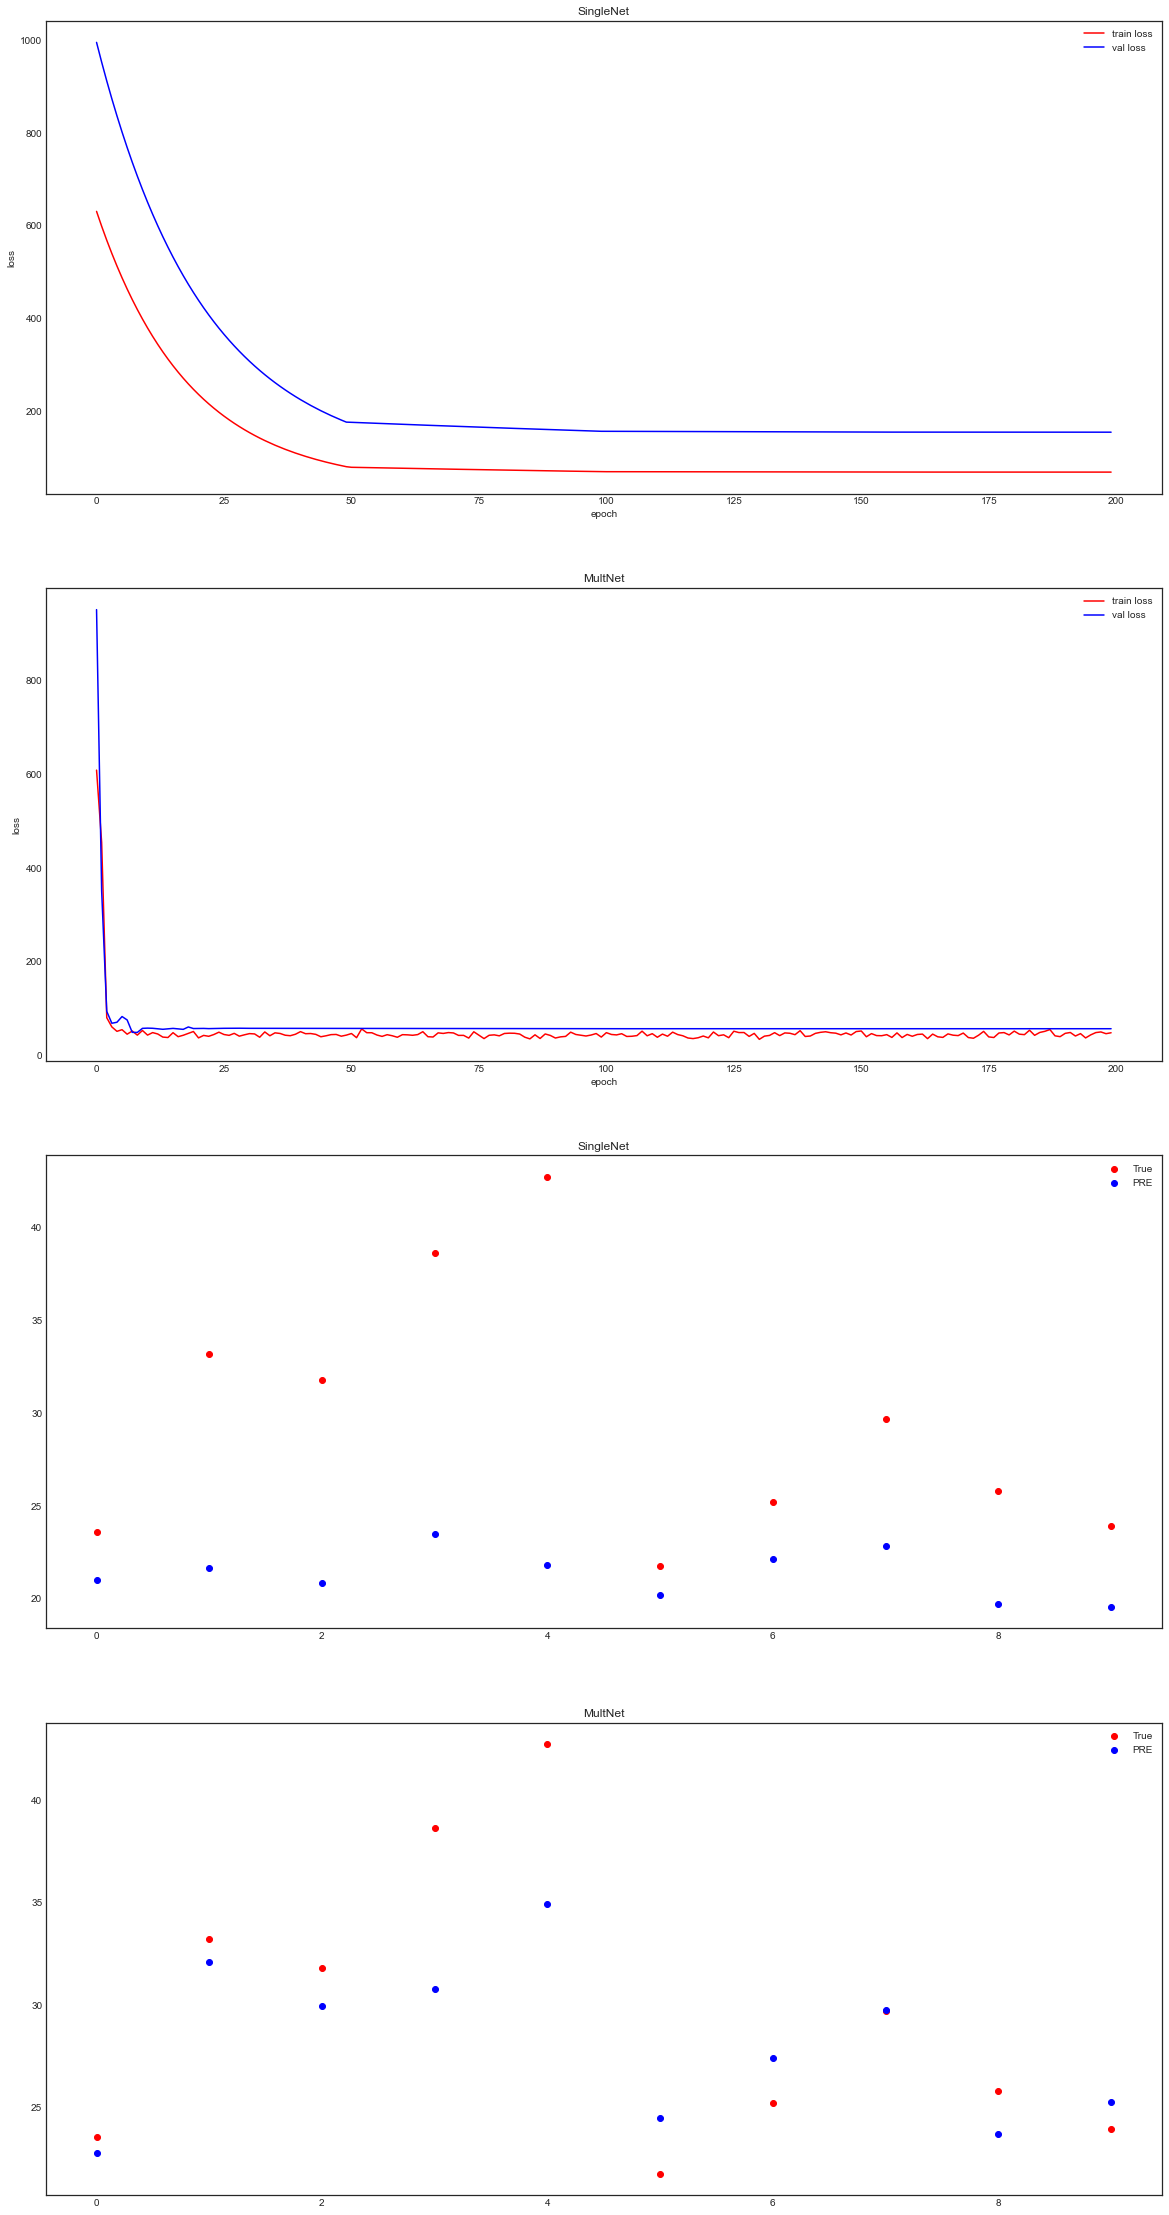

In [9]:
fig = plt.figure(figsize=(20,40))
plt.subplot(411)
x = range(epochs)
plt.title("SingleNet")
plt.plot(x, StrainLOSS, label='train loss', color='r')
plt.plot(x, SvalLOSS, label='val loss', color='b')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(413)
x=range(10)
plt.title("SingleNet")
plt.scatter(np.array(x),np.array(SY[-10:]),label="True",color='r')
plt.scatter(np.array(x),np.array(SYHat[-10:]),label='PRE',color='b')
plt.legend()

plt.subplot(412)
x = range(epochs)
plt.title("MultNet")
plt.plot(x, MtrainLOSS, label='train loss', color='r')
plt.plot(x, MvalLOSS, label='val loss', color='b')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(414)
x=range(10)
plt.title("MultNet")
plt.scatter(np.array(x),np.array(MY[-10:]),label="True",color='r')
plt.scatter(np.array(x),np.array(MYHat[-10:]),label='PRE',color='b')
plt.legend()
plt.show()


## 分析模型

In [10]:
import torch

model = torch.load("output/SingleNetparams_200.pth")
for k,v in model.items():
    print(k)


layer1.0.weight
layer1.0.bias


In [11]:
model['layer1.0.weight'],model['layer1.0.bias'],data.columns

(tensor([[-3.2379,  0.9029, -0.2220, -0.9949, -3.7642, -3.4709,  1.3431, -3.0438,
          -3.7554, -1.2957, -2.7890,  3.7018, -2.8491]]),
 tensor([10.0528]),
 Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PIRATIO', 'B', 'LSTAT', 'MEDV'],
       dtype='object'))

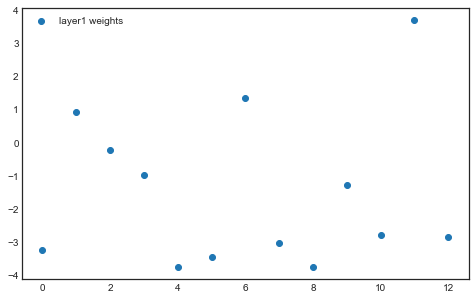

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8,5))
plt.scatter(range(len(model['layer1.0.weight'].view(13))), model['layer1.0.weight'].view(13),label='layer1 weights')
plt.legend()
plt.show()

# 预测

In [13]:
predata=data.iloc[300:,:-1].to_numpy()
trueLabel = data.iloc[300:,-1].to_numpy()
trueLabel, predata.shape

(array([24.8, 22. , 26.4, 33.1, 36.1, 28.4, 33.4, 28.2, 22.8, 20.3, 16.1,
        22.1, 19.4, 21.6, 23.8, 16.2, 17.8, 19.8, 23.1, 21. , 23.8, 23.1,
        20.4, 18.5, 25. , 24.6, 23. , 22.2, 19.3, 22.6, 19.8, 17.1, 19.4,
        22.2, 20.7, 21.1, 19.5, 18.5, 20.6, 19. , 18.7, 32.7, 16.5, 23.9,
        31.2, 17.5, 17.2, 23.1, 24.5, 26.6, 22.9, 24.1, 18.6, 30.1, 18.2,
        20.6, 17.8, 21.7, 22.7, 22.6, 25. , 19.9, 20.8, 16.8, 21.9, 27.5,
        21.9, 50. , 50. , 50. , 50. , 50. , 13.3, 11.3, 12.3, 11.5, 15.1,
        23.2, 13.8, 13.1, 12.5,  8.5,  6.3, 12.1, 17.2, 14.2, 13.4, 11.7,
        11. ,  9.5, 14.5, 16.1, 14.3, 12.8, 17.1, 18.4, 15.4, 14.9, 12.6,
        14.1, 13. , 13.4, 15.2, 16.1, 17.8, 14.9, 14.1, 12.7, 13.5, 14.9,
        20. , 16.4, 17.7, 19.5, 20.2, 21.4, 19.9, 19. , 19.1, 19.9, 19.6,
        23.2, 29.8, 13.8, 13.3, 16.7, 23. , 23.7, 25. , 21.8, 20.6, 21.2,
        19.1, 20.6, 15.2,  7. ,  8.1, 13.6, 20.1, 21.8, 24.5, 23.1, 19.7,
        18.3, 21.2, 17.5, 16.8, 22.4, 

## 单层神经网络

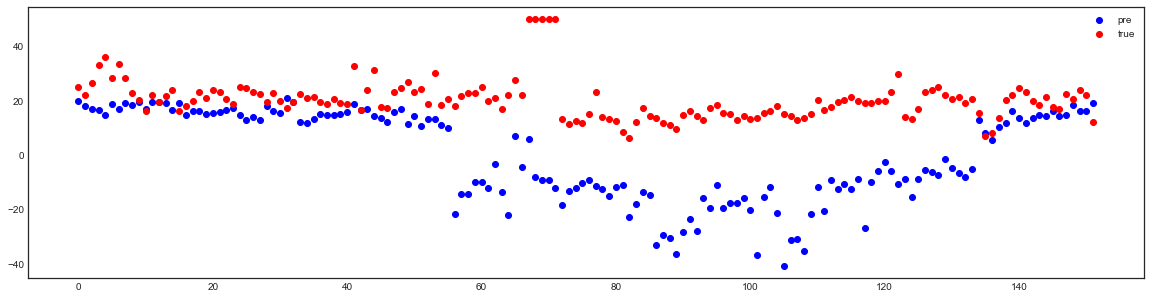

In [14]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline


model = SingleLayerNet()
model.load_state_dict(torch.load("output/SingleNetparams_200.pth"))
model.eval()
yHat=[]
for x in predata:
    yHat.append(model(torch.Tensor(x)))
    
fig = plt.figure(figsize=(20,5))
plt.scatter(x=np.array(range(len(yHat))),y=np.array(yHat),c='b',label='pre')
plt.scatter(x=np.array(range(len(yHat))),y=np.array(trueLabel),c='r',label='true')
plt.legend()
plt.show()

## 多层神经网络

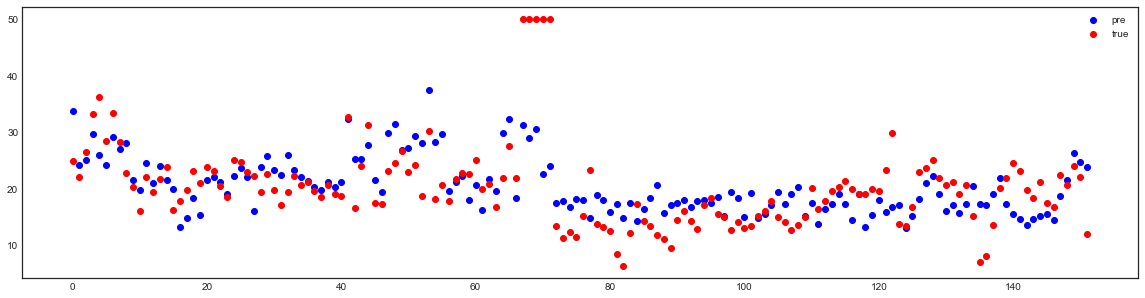

In [15]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline


model = net()
model.load_state_dict(torch.load("output/multNetparams_200.pth"))
model.eval()
yHat=[]
for x in predata:
    yHat.append(model(torch.Tensor(x)))
    
fig = plt.figure(figsize=(20,5))
plt.scatter(x=np.array(range(len(yHat))),y=np.array(yHat),c='b',label='pre')
plt.scatter(x=np.array(range(len(yHat))),y=np.array(trueLabel),c='r',label='true')
plt.legend()
plt.show()